In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

from itertools import combinations
from copy import deepcopy

In [309]:
hf_res = {}
hf_summary = None
for model in os.listdir('hf_classification_res/results'):
    if model == 'gpt2-xl':
        continue
    hf_res[model] = {}
    for dataset in os.listdir(os.path.join('hf_classification_res/results', model)):
        if dataset == 'summary.csv':
            summary = pd.read_csv(f'hf_classification_res/results/{model}/{dataset}')
            
            new_row = pd.DataFrame(summary.iloc[:, -1]).T.reset_index()
            new_row.columns = ['model'] + summary.iloc[:, 0].tolist()[:-1] + ['average']
            
            hf_summary = pd.concat([hf_summary, new_row], ignore_index=True)
            
        if not dataset.startswith('predictions'):
            continue
        print(model, dataset)
        with open(f'lm_evaluation_data/{dataset[12:]}l') as tgt:
            with open(f'hf_classification_res/results/{model}/{dataset}') as f:
                data = json.load(f)
                for i, line in enumerate(tgt):
                    data[i]['target_index'] = json.loads(line)['target_index']
        data = pd.DataFrame(data)
        hf_res[model][dataset] = data


opt-2.7b predictions_race-middle.json
opt-2.7b predictions_race-high.json
opt-2.7b predictions_winogrande.json
opt-2.7b predictions_piqa.json
opt-2.7b predictions_rte.json
opt-2.7b predictions_boolq.json
opt-2.7b predictions_hellaswag.json
opt-2.7b predictions_arc-easy.json
opt-2.7b predictions_arc-challenge.json
gpt-neo-2.7B predictions_race-middle.json
gpt-neo-2.7B predictions_race-high.json
gpt-neo-2.7B predictions_winogrande.json
gpt-neo-2.7B predictions_piqa.json
gpt-neo-2.7B predictions_rte.json
gpt-neo-2.7B predictions_boolq.json
gpt-neo-2.7B predictions_hellaswag.json
gpt-neo-2.7B predictions_arc-easy.json
gpt-neo-2.7B predictions_arc-challenge.json
Cerebras-GPT-1.3B predictions_race-middle.json
Cerebras-GPT-1.3B predictions_race-high.json
Cerebras-GPT-1.3B predictions_winogrande.json
Cerebras-GPT-1.3B predictions_piqa.json
Cerebras-GPT-1.3B predictions_rte.json
Cerebras-GPT-1.3B predictions_boolq.json
Cerebras-GPT-1.3B predictions_hellaswag.json
Cerebras-GPT-1.3B predictions_a

In [359]:
def evaluate_on_dataset(*predictions, key='acc_norm_ans_ctx'):
    if key not in predictions[0].columns:
        key = 'acc_norm_tokens'
    cur_pred = pd.Series(deepcopy(predictions[0][key].to_dict())).apply(lambda x: [0 for _ in x])
    for prediction in predictions:
        for i, pred in enumerate(prediction[key]):
            for j in range(len(cur_pred[i])):
                cur_pred[i][j] += pred[j]
    return (cur_pred.apply(np.argmax) == predictions[0]['target_index']).mean()

In [49]:
hf_res.keys()

dict_keys(['opt-2.7b', 'gpt-neo-2.7B', 'Cerebras-GPT-1.3B', 'gpt-neo-1.3B', 'Cerebras-GPT-2.7B', 'opt-1.3b'])

In [6]:
evaluate_on_dataset(
    hf_res['opt-2.7b']['predictions_race-middle.json'],
    hf_res['gpt-neo-2.7B']['predictions_race-middle.json']
)

0.4616991643454039

In [9]:
group1 = [
'Cerebras-GPT-1.3B', 'gpt-neo-1.3B', 'opt-1.3b'
]
group2 = [
'opt-2.7b', 'gpt-neo-2.7B',
]
model_groups = [
    group1, group2
]

expert_sets = []
for group in model_groups:
    for n_experts in range(1, len(group) + 1):
        for experts in combinations(group, n_experts):
            expert_sets.append(experts)
expert_sets

[('Cerebras-GPT-1.3B',),
 ('gpt-neo-1.3B',),
 ('opt-1.3b',),
 ('Cerebras-GPT-1.3B', 'gpt-neo-1.3B'),
 ('Cerebras-GPT-1.3B', 'opt-1.3b'),
 ('gpt-neo-1.3B', 'opt-1.3b'),
 ('Cerebras-GPT-1.3B', 'gpt-neo-1.3B', 'opt-1.3b'),
 ('opt-2.7b',),
 ('gpt-neo-2.7B',),
 ('opt-2.7b', 'gpt-neo-2.7B')]

In [10]:
evaluation_res = []

for expert_set in expert_sets:
    for dataset in hf_res['opt-1.3b'].keys():
        predictions = []
        for model in expert_set:
            predictions.append(hf_res[model][dataset])
        metric = evaluate_on_dataset(*predictions)
        evaluation_res.append(dict(
            model='+'.join(expert_set),
            dataset=dataset[12:-5],
            metric=metric,
            n_models=len(expert_set)
        ))

In [11]:
df = pd.DataFrame(evaluation_res).pivot('model', 'dataset', 'metric')

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/2894976032.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = pd.DataFrame(evaluation_res).pivot('model', 'dataset', 'metric')


In [12]:
df['average'] = df.mean(1)
df['n_models'] = df.index.map(lambda x: len(x.split('+')))
df.columns.name = None

In [13]:
df

,arc-challenge,arc-easy,boolq,hellaswag,piqa,race-high,race-middle,rte,winogrande,average,n_models
model,,,,,,,,,,,
Cerebras-GPT-1.3B,0.309727,0.513889,0.619572,0.496614,0.711099,0.378216,0.447772,0.534296,0.595107,0.511810,1
Cerebras-GPT-1.3B+gpt-neo-1.3B,0.312287,0.514310,0.619266,0.501792,0.715452,0.378216,0.447075,0.541516,0.590371,0.513365,2
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b,0.316553,0.503788,0.615902,0.513941,0.717628,0.379931,0.447075,0.548736,0.594317,0.515319,3
Cerebras-GPT-1.3B+opt-1.3b,0.312287,0.511785,0.619266,0.506473,0.717084,0.380503,0.444290,0.541516,0.594317,0.514169,2
gpt-neo-1.3B,0.316553,0.505051,0.612844,0.514639,0.714363,0.381933,0.436630,0.548736,0.591949,0.513633,1
gpt-neo-1.3B+opt-1.3b,0.323379,0.495791,0.612844,0.525493,0.715996,0.377073,0.440111,0.548736,0.588792,0.514246,2
gpt-neo-2.7B,0.348123,0.541667,0.615291,0.561840,0.731774,0.382504,0.453343,0.545126,0.577743,0.528601,1
opt-1.3b,0.323379,0.408249,0.621713,0.538936,0.707291,0.368210,0.401114,0.527076,0.595107,0.499008,1
opt-2.7b,0.316553,0.429293,0.621713,0.607648,0.719804,0.382504,0.461699,0.527076,0.621152,0.520827,1


In [12]:
df = df.iloc[[0, 4, 7, 1, 3, 5, 2, 6, 8, 9]]

In [13]:
print(df.style.to_latex())

\begin{tabular}{lrrrrrrrrrrr}
 & arc-challenge & arc-easy & boolq & hellaswag & piqa & race-high & race-middle & rte & winogrande & average & n_models \\
model &  &  &  &  &  &  &  &  &  &  &  \\
Cerebras-GPT-1.3B & 0.273038 & 0.465067 & 0.586544 & 0.381099 & 0.669750 & 0.361921 & 0.411560 & 0.523466 & 0.519337 & 0.465754 & 1 \\
gpt-neo-1.3B & 0.316553 & 0.503367 & 0.612844 & 0.484963 & 0.714908 & 0.374786 & 0.434540 & 0.548736 & 0.549329 & 0.504447 & 1 \\
opt-1.3b & 0.323379 & 0.408249 & 0.621713 & 0.538936 & 0.707291 & 0.368210 & 0.401114 & 0.527076 & 0.595107 & 0.499008 & 1 \\
Cerebras-GPT-1.3B+gpt-neo-1.3B & 0.292662 & 0.503788 & 0.618043 & 0.437562 & 0.692057 & 0.374500 & 0.448468 & 0.537906 & 0.536701 & 0.493521 & 2 \\
Cerebras-GPT-1.3B+opt-1.3b & 0.304608 & 0.513047 & 0.618043 & 0.472018 & 0.705114 & 0.378502 & 0.442201 & 0.537906 & 0.584057 & 0.506166 & 2 \\
gpt-neo-1.3B+opt-1.3b & 0.316553 & 0.505051 & 0.612844 & 0.514639 & 0.714363 & 0.381933 & 0.436630 & 0.548736 & 0.591949 

In [14]:
a = []
for i in df.index:
    a.append(df.loc[i])
pd.concat(a, axis=1).T.max(1)

Cerebras-GPT-1.3B                          1.0
gpt-neo-1.3B                               1.0
opt-1.3b                                   1.0
Cerebras-GPT-1.3B+gpt-neo-1.3B             2.0
Cerebras-GPT-1.3B+opt-1.3b                 2.0
gpt-neo-1.3B+opt-1.3b                      2.0
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b    3.0
gpt-neo-2.7B                               1.0
opt-2.7b                                   1.0
opt-2.7b+gpt-neo-2.7B                      2.0
dtype: float64

In [15]:
df

,arc-challenge,arc-easy,boolq,hellaswag,piqa,race-high,race-middle,rte,winogrande,average,n_models
model,,,,,,,,,,,
Cerebras-GPT-1.3B,0.273038,0.465067,0.586544,0.381099,0.669750,0.361921,0.411560,0.523466,0.519337,0.465754,1
gpt-neo-1.3B,0.316553,0.503367,0.612844,0.484963,0.714908,0.374786,0.434540,0.548736,0.549329,0.504447,1
opt-1.3b,0.323379,0.408249,0.621713,0.538936,0.707291,0.368210,0.401114,0.527076,0.595107,0.499008,1
Cerebras-GPT-1.3B+gpt-neo-1.3B,0.292662,0.503788,0.618043,0.437562,0.692057,0.374500,0.448468,0.537906,0.536701,0.493521,2
Cerebras-GPT-1.3B+opt-1.3b,0.304608,0.513047,0.618043,0.472018,0.705114,0.378502,0.442201,0.537906,0.584057,0.506166,2
gpt-neo-1.3B+opt-1.3b,0.316553,0.505051,0.612844,0.514639,0.714363,0.381933,0.436630,0.548736,0.591949,0.513633,2
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b,0.309727,0.513889,0.619572,0.496614,0.711099,0.378216,0.447772,0.534296,0.595107,0.511810,3
gpt-neo-2.7B,0.348123,0.541667,0.615291,0.561840,0.731774,0.382504,0.453343,0.545126,0.577743,0.528601,1
opt-2.7b,0.316553,0.429293,0.621713,0.607648,0.719804,0.382504,0.461699,0.527076,0.621152,0.520827,1


In [437]:
def beautiful_metrics(table, model_sep='+'):
    beautiful = table.copy()
    metric_cols = table.columns
    for model, row in table.iterrows():
        base_models = model.split(model_sep)
        maximum_res = []
        for base_model in base_models:
            maximum_res.append(table.loc[base_model, metric_cols])
#         beautiful.loc[model, metric_cols] -= pd.concat(maximum_res, axis=1).T.max(0)
        max_vals = pd.concat(maximum_res, axis=1).T.max(0)
        beautiful.loc[model, metric_cols] = (beautiful.loc[model, metric_cols] - max_vals) / max_vals * 100
    
    return beautiful
        
# beautiful = beautiful_metrics(df)

In [19]:
beautiful

,arc-challenge,arc-easy,boolq,hellaswag,piqa,race-high,race-middle,rte,winogrande,average,n_models
model,,,,,,,,,,,
Cerebras-GPT-1.3B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
gpt-neo-1.3B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
opt-1.3b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Cerebras-GPT-1.3B+gpt-neo-1.3B,-0.075472,0.000836,0.008483,-0.097741,-0.031963,-0.000763,0.032051,-0.019737,-0.022989,-0.021661,2
Cerebras-GPT-1.3B+opt-1.3b,-0.058047,0.103167,-0.005903,-0.124169,-0.003077,0.027950,0.074450,0.020548,-0.018568,0.014344,2
gpt-neo-1.3B+opt-1.3b,-0.021108,0.003344,-0.014265,-0.045085,-0.000761,0.019069,0.004808,0.000000,-0.005305,0.018209,2
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b,-0.042216,0.020903,-0.003443,-0.078529,-0.005327,0.009153,0.030449,-0.026316,0.000000,0.014596,3
gpt-neo-2.7B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
opt-2.7b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


In [431]:
def color_positive_red(val):
    """
    Takes a scalar and returns a string with
    the css property 'color: red' for negative
    strings, 'color: green' for positive, black otherwise.
    """
    if val < 0:
        color = 'red'
    elif val > 0:
        color = 'green'
    else:
        color = 'black'
    return 'color: %s' % color

def style_df(df):
    return df.style.applymap(color_positive_red)

def colorize(val):
    if val < 0:
        # apply some LaTeX formatting
        return "\\textcolor{BrickRed}{" + '{:.1f}'.format(val) + "}"
    elif val > 0:
        return "\\textcolor{ForestGreen}{" + '{:.1f}'.format(val) + "}"
    else:
        return '{:.1f}'.format(val)

def latex_with_color(df):
    # apply colorize to the entire DataFrame
    new_df = df.applymap(colorize)
    # return as LaTeX
    return new_df.style.to_latex()  # prevent LaTeX commands from being escaped


# print(latex_with_color(beautiful.iloc[:, :-1] * 10))

# Alternative ensembling methods

## What about Confedence

In [94]:
from scipy.special import softmax
from scipy.stats import entropy

def calc_entropy(prediction, T=1.0, key='acc_norm_ans_ctx'):
    if key not in prediction.columns:
        key = 'acc_norm_tokens'
    entropies = []
    for pred in prediction[key]:
        sm = softmax([x / T for x in pred])
        entropies.append(entropy(sm))
#         print(sm)
#         print(entropy(sm))
#         break
    return entropies

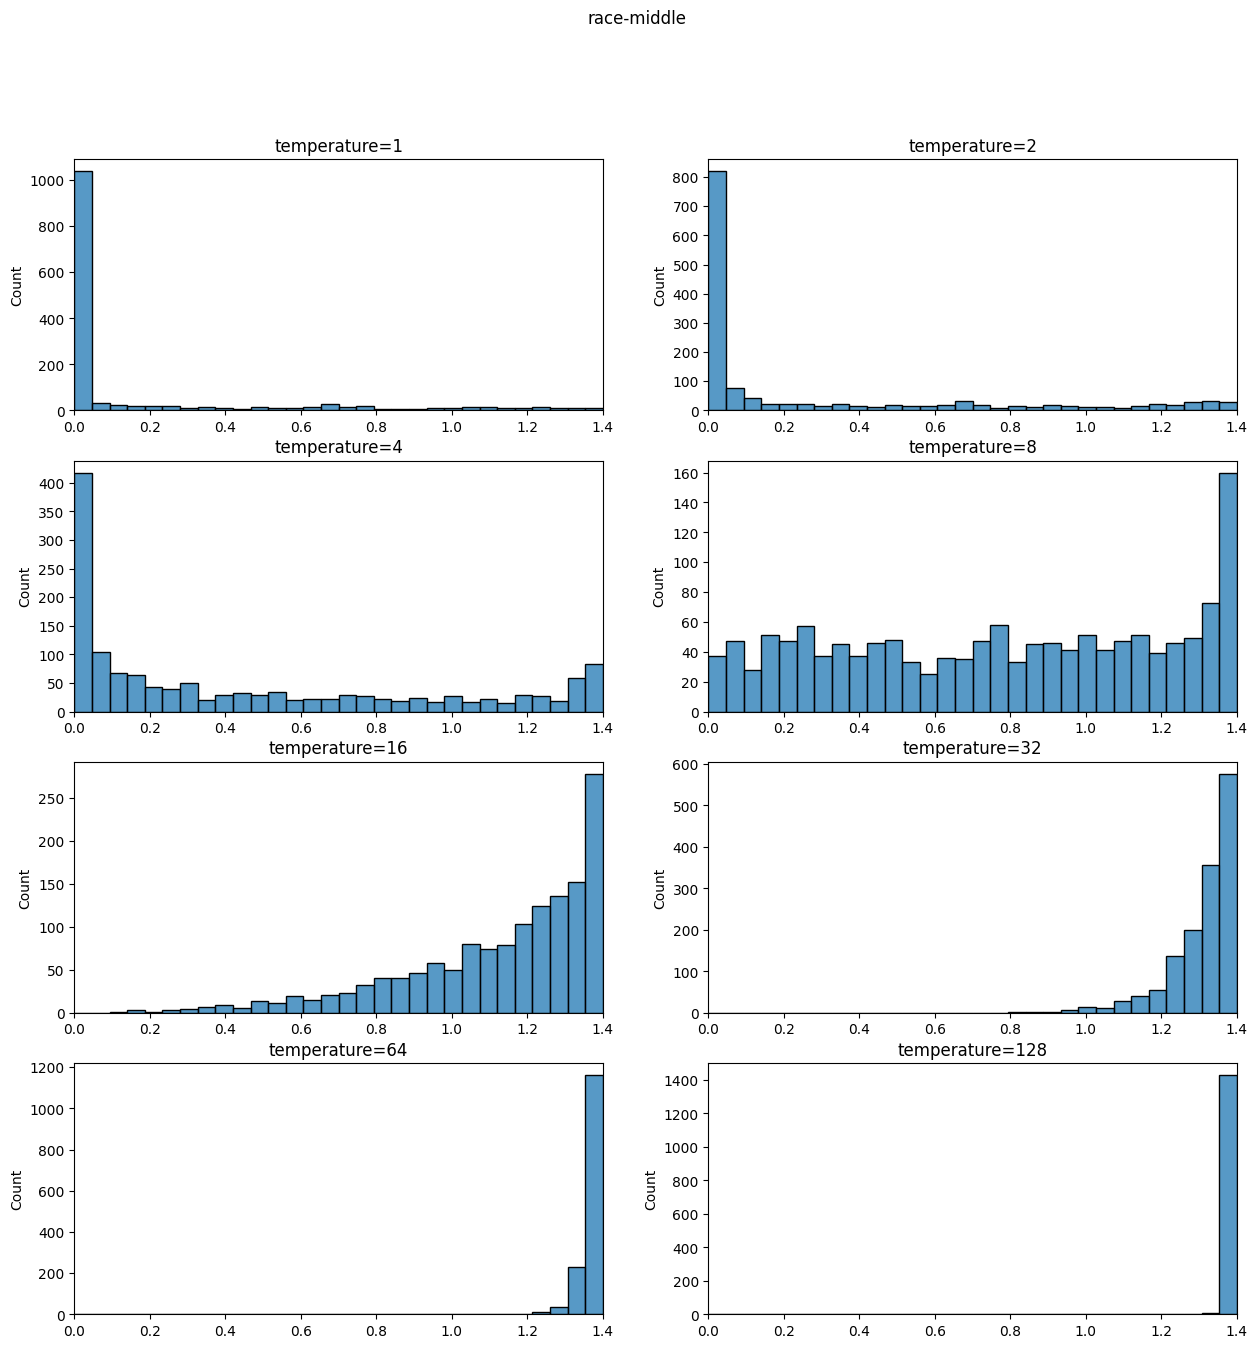

In [95]:
entropies = []

dataset = next(iter(hf_res['gpt-neo-1.3B']))
plt.figure(figsize=(15, 15))
plt.suptitle(dataset[12:-5])
temperatures = [1, 2, 4, 8, 16, 32, 64, 128]

for idx, temperature in enumerate(temperatures, 1):

    predictions = []
    entr = calc_entropy(hf_res['gpt-neo-1.3B'][dataset], temperature)
    plt.subplot(4, 2, idx)
    plt.title(f'temperature={temperature}')
    sns.histplot(entr, bins=30, kde=False, stat='count', element='bars', binrange=(0, 1.4))
    plt.xlim(0, 1.4)


opt-2.7b
gpt-neo-2.7B
Cerebras-GPT-1.3B
gpt-neo-1.3B
opt-1.3b


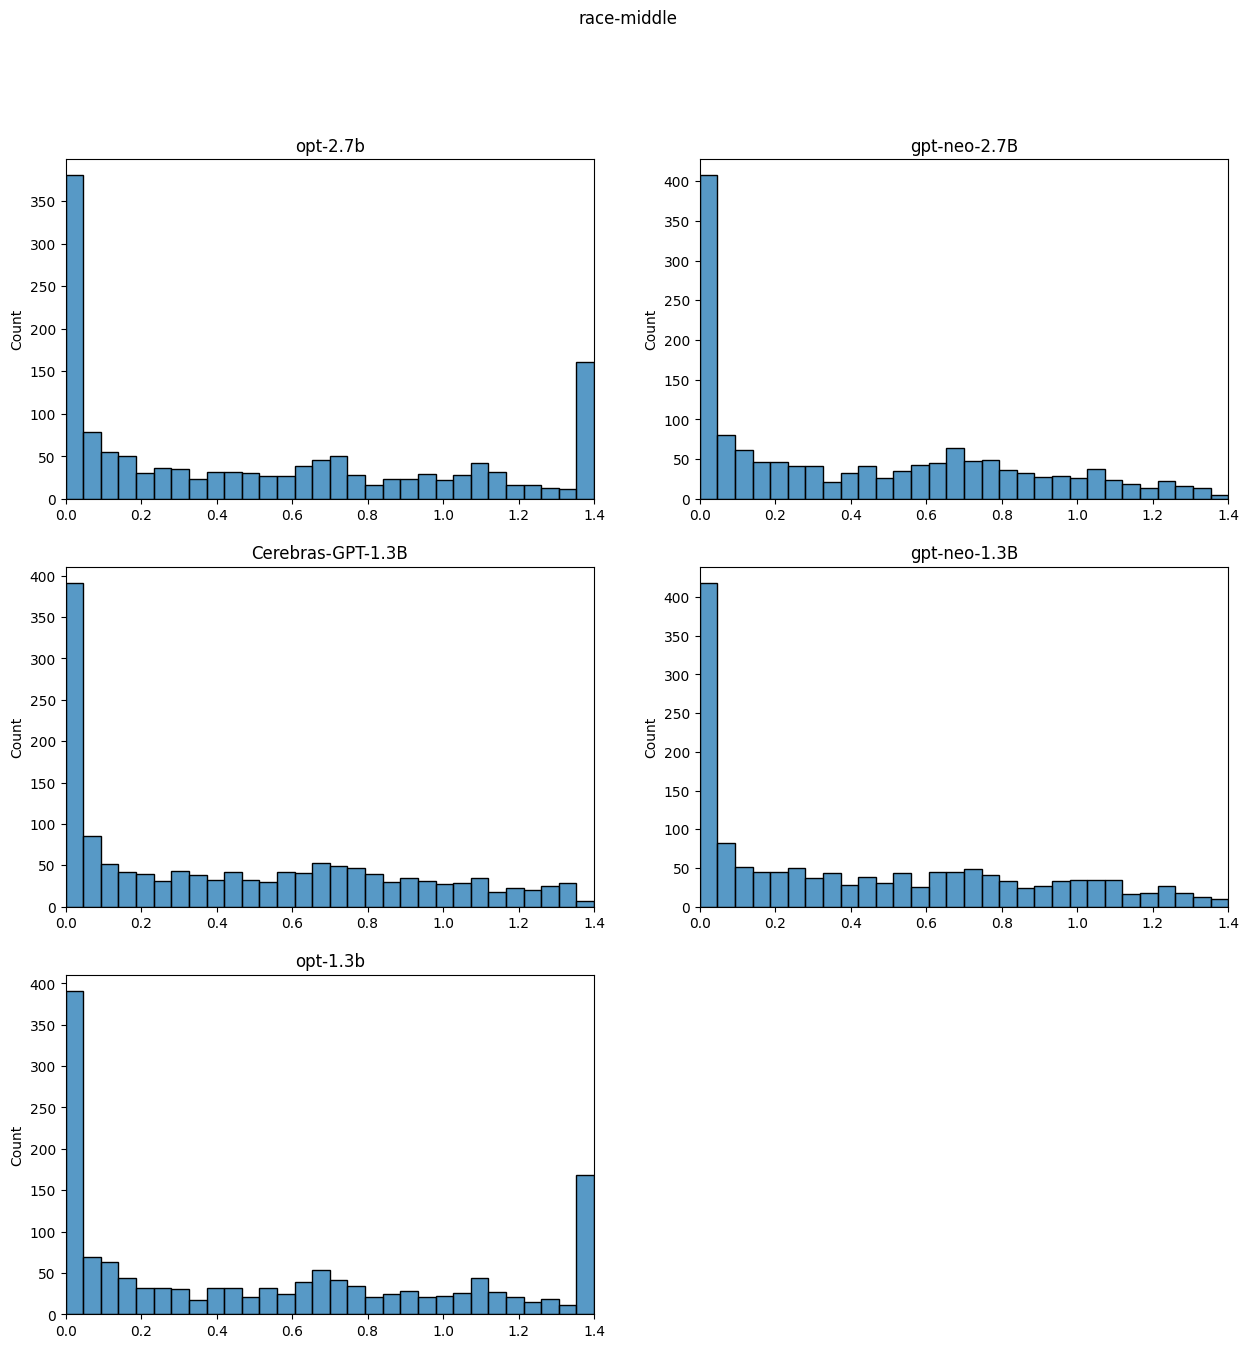

opt-2.7b
gpt-neo-2.7B
Cerebras-GPT-1.3B
gpt-neo-1.3B
opt-1.3b


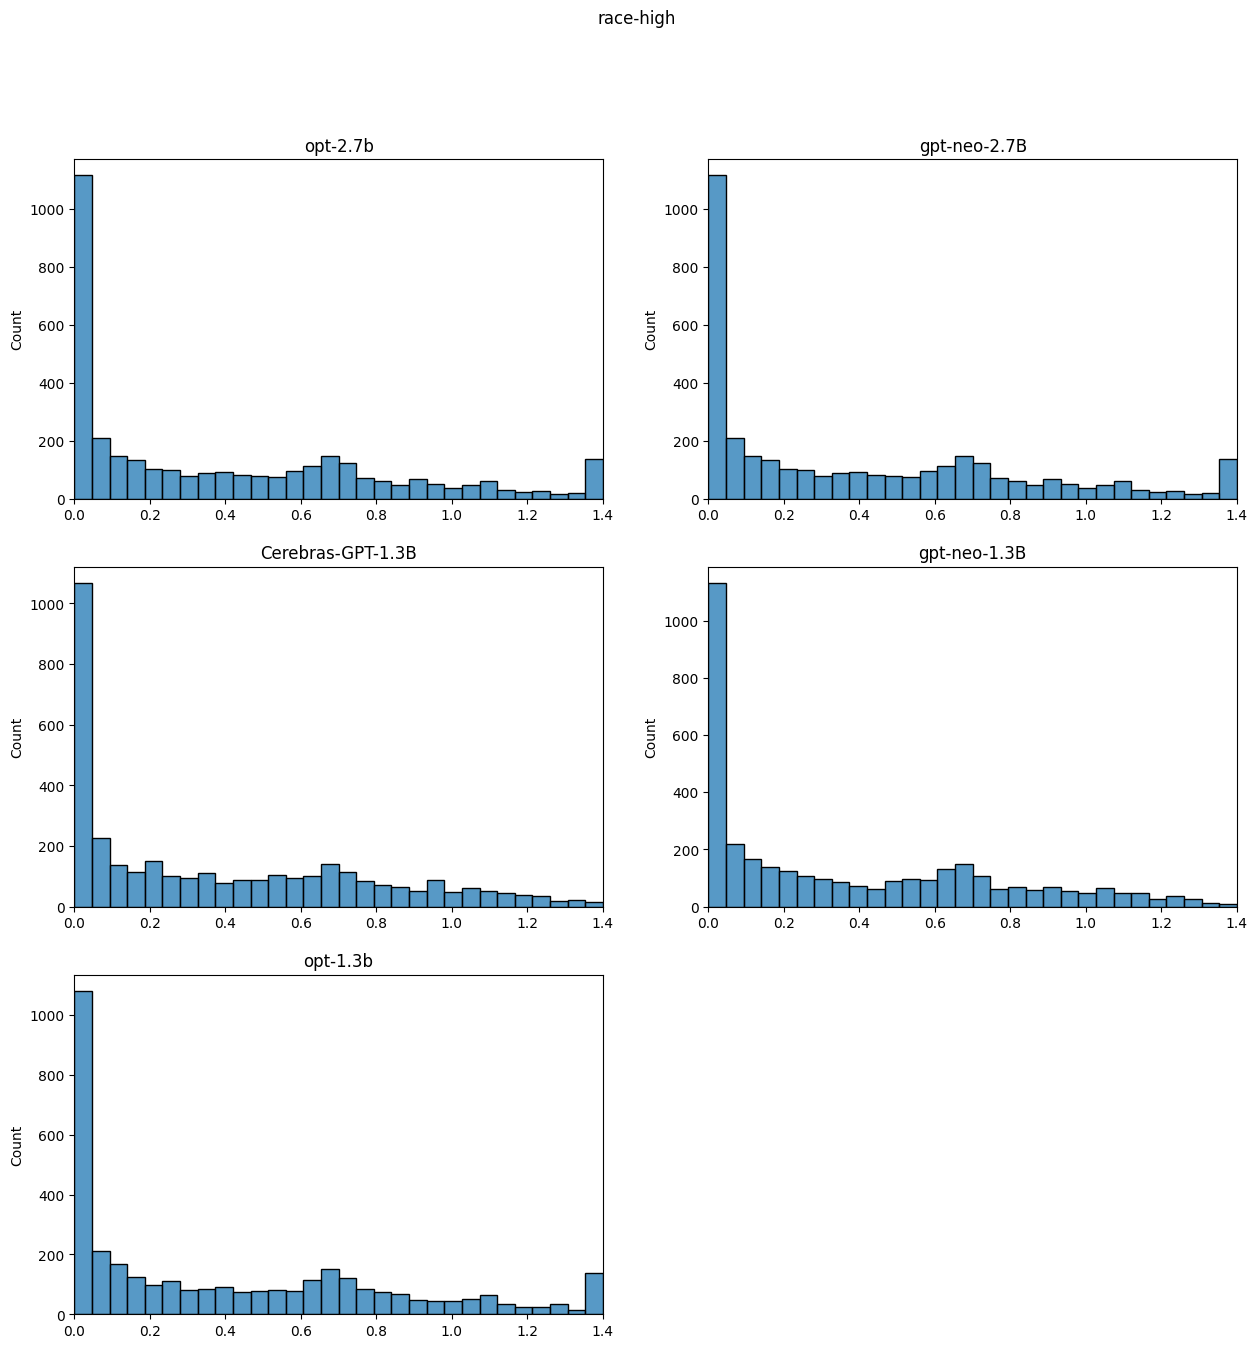

opt-2.7b
gpt-neo-2.7B
Cerebras-GPT-1.3B
gpt-neo-1.3B
opt-1.3b


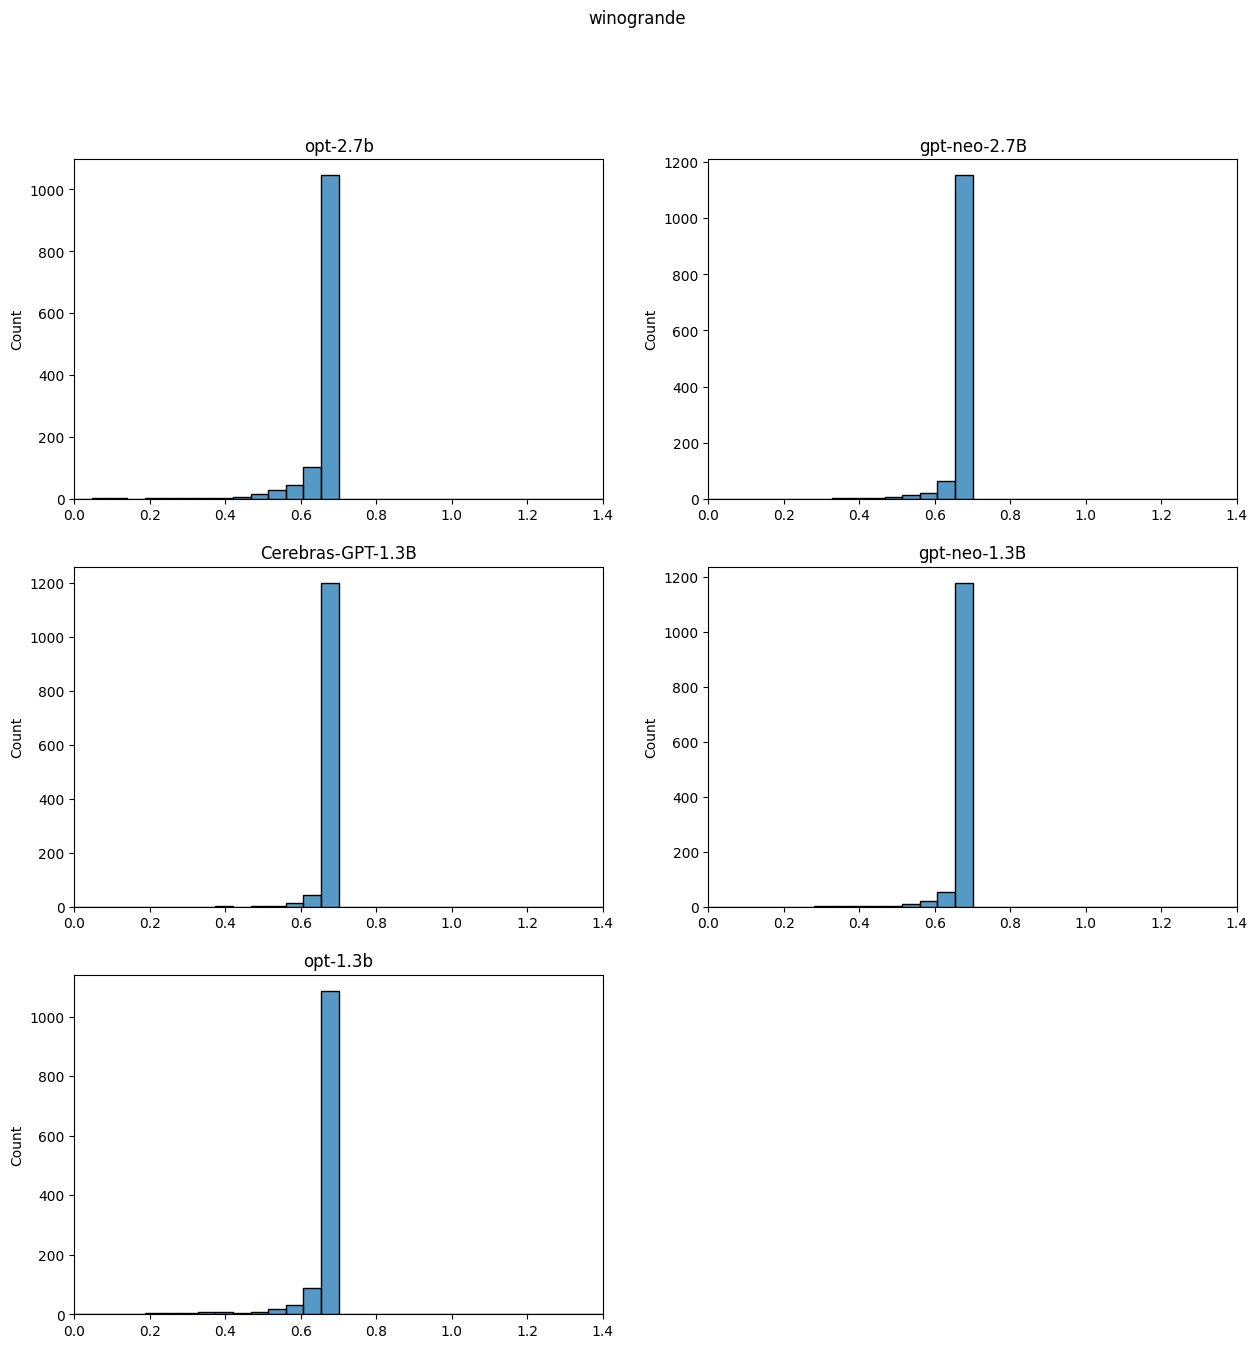

opt-2.7b
gpt-neo-2.7B
Cerebras-GPT-1.3B
gpt-neo-1.3B
opt-1.3b


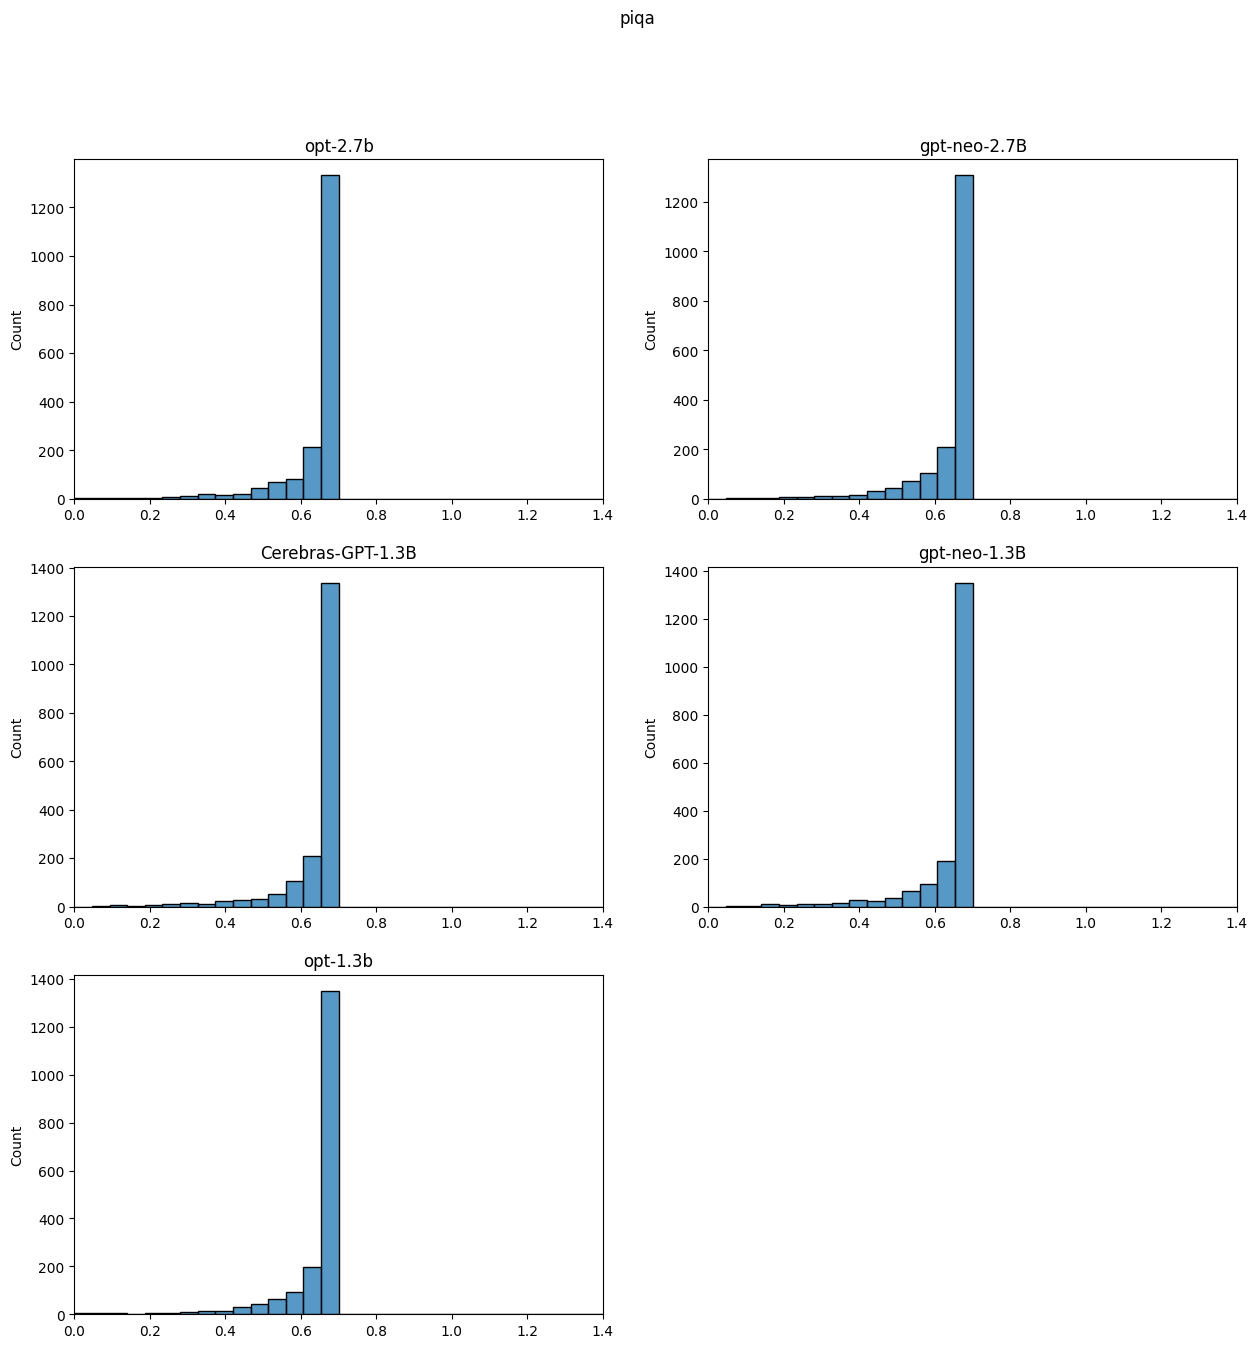

opt-2.7b
gpt-neo-2.7B
Cerebras-GPT-1.3B
gpt-neo-1.3B
opt-1.3b


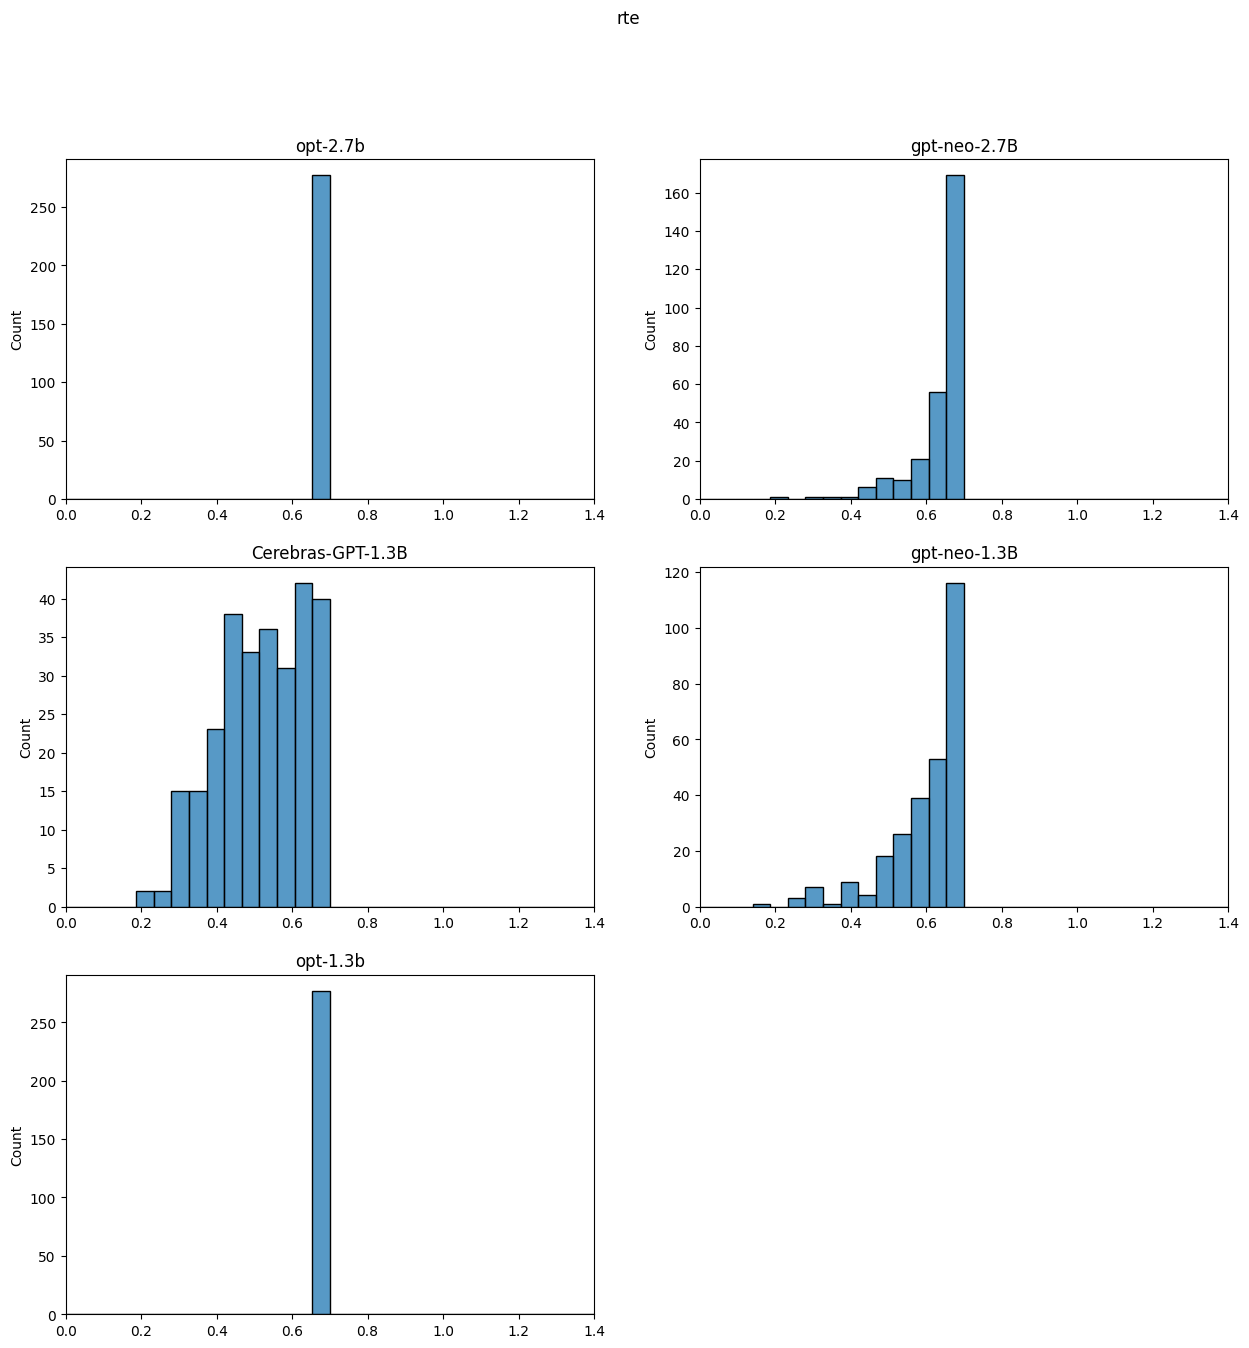

opt-2.7b
gpt-neo-2.7B
Cerebras-GPT-1.3B
gpt-neo-1.3B
opt-1.3b


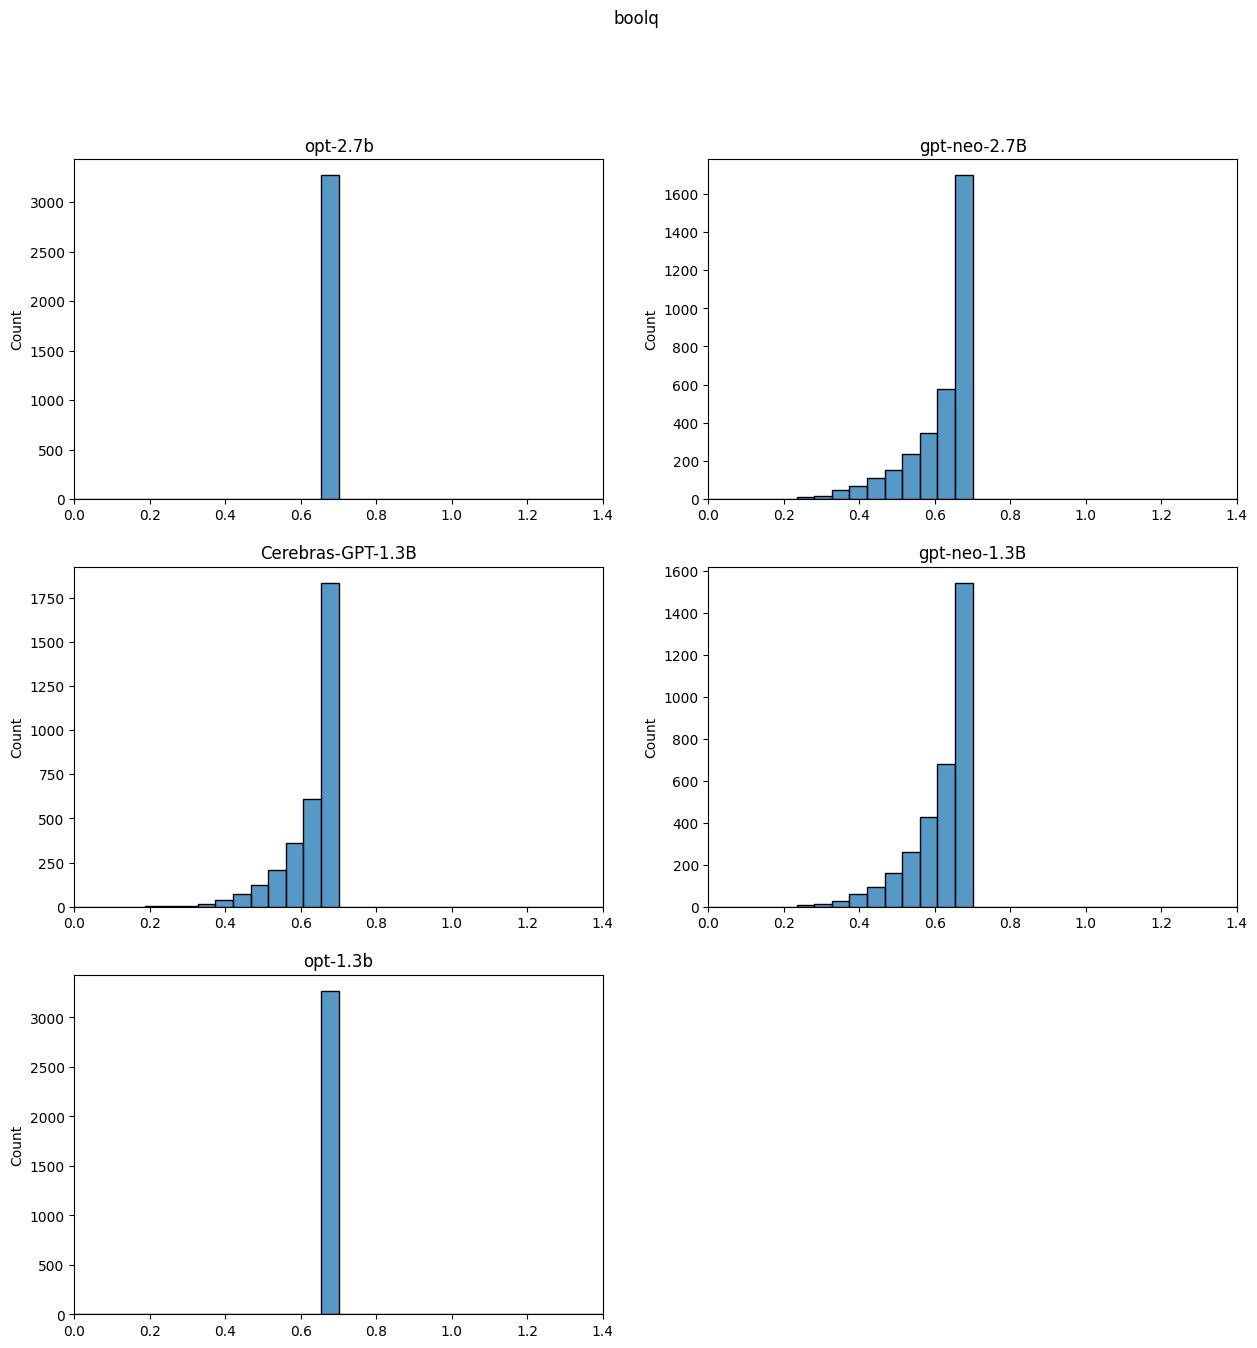

opt-2.7b
gpt-neo-2.7B
Cerebras-GPT-1.3B
gpt-neo-1.3B
opt-1.3b


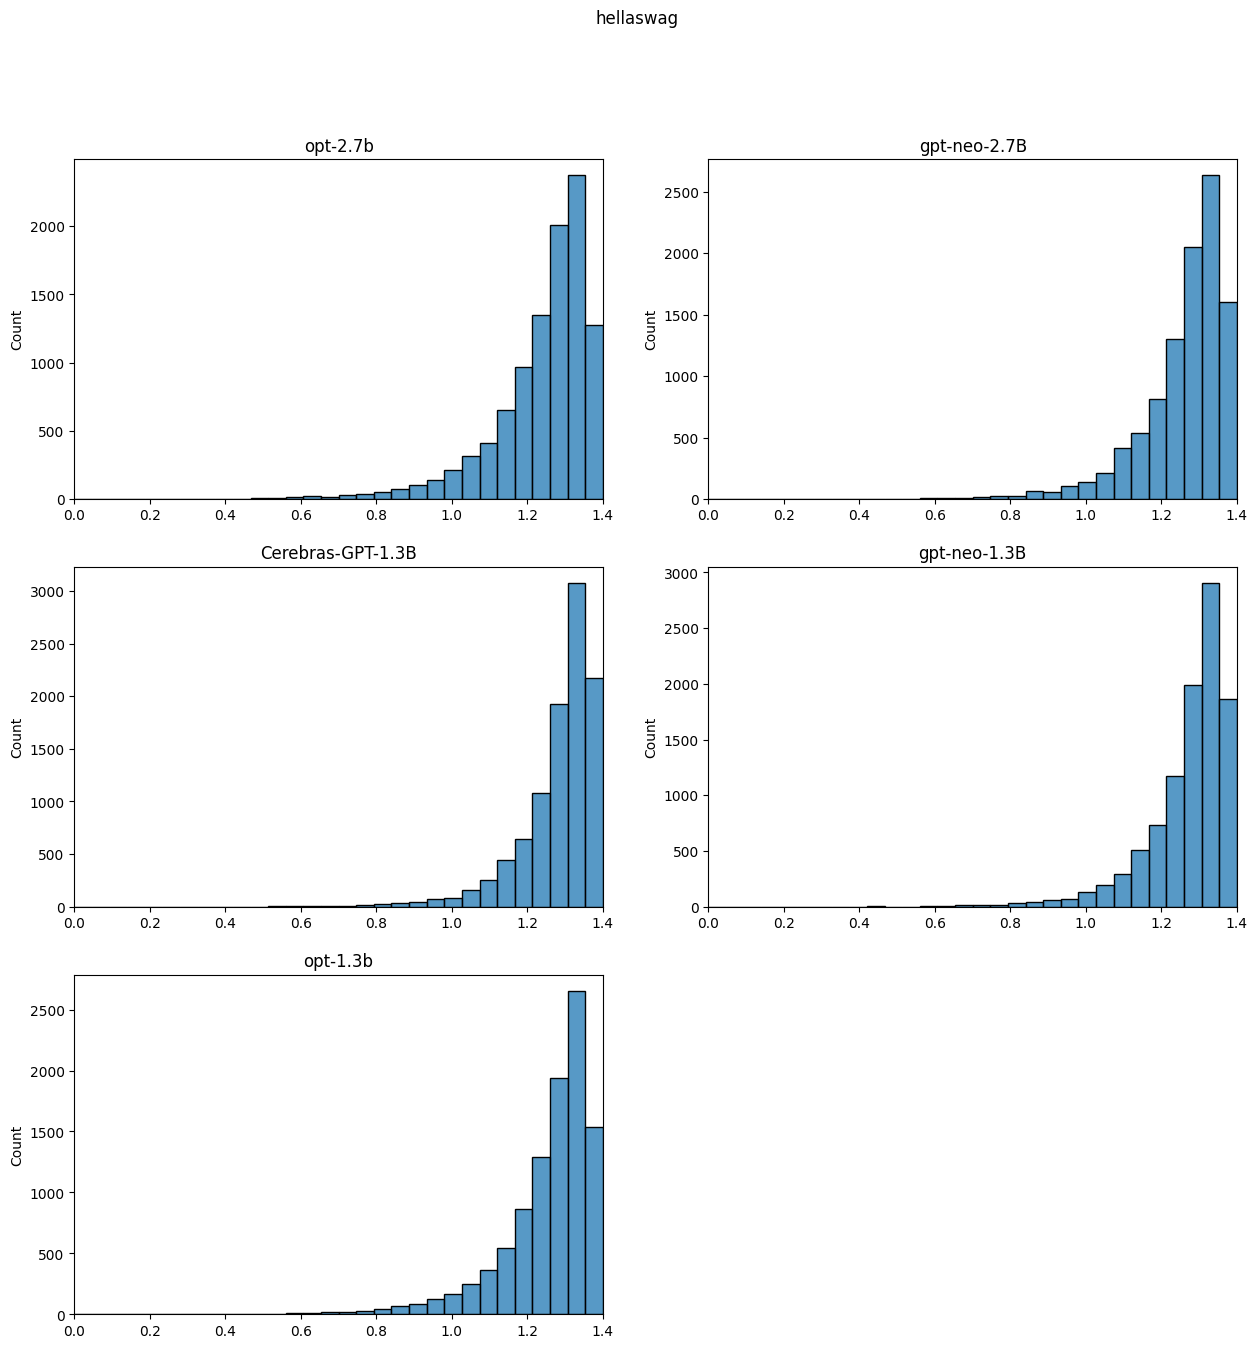

opt-2.7b
gpt-neo-2.7B
Cerebras-GPT-1.3B
gpt-neo-1.3B
opt-1.3b


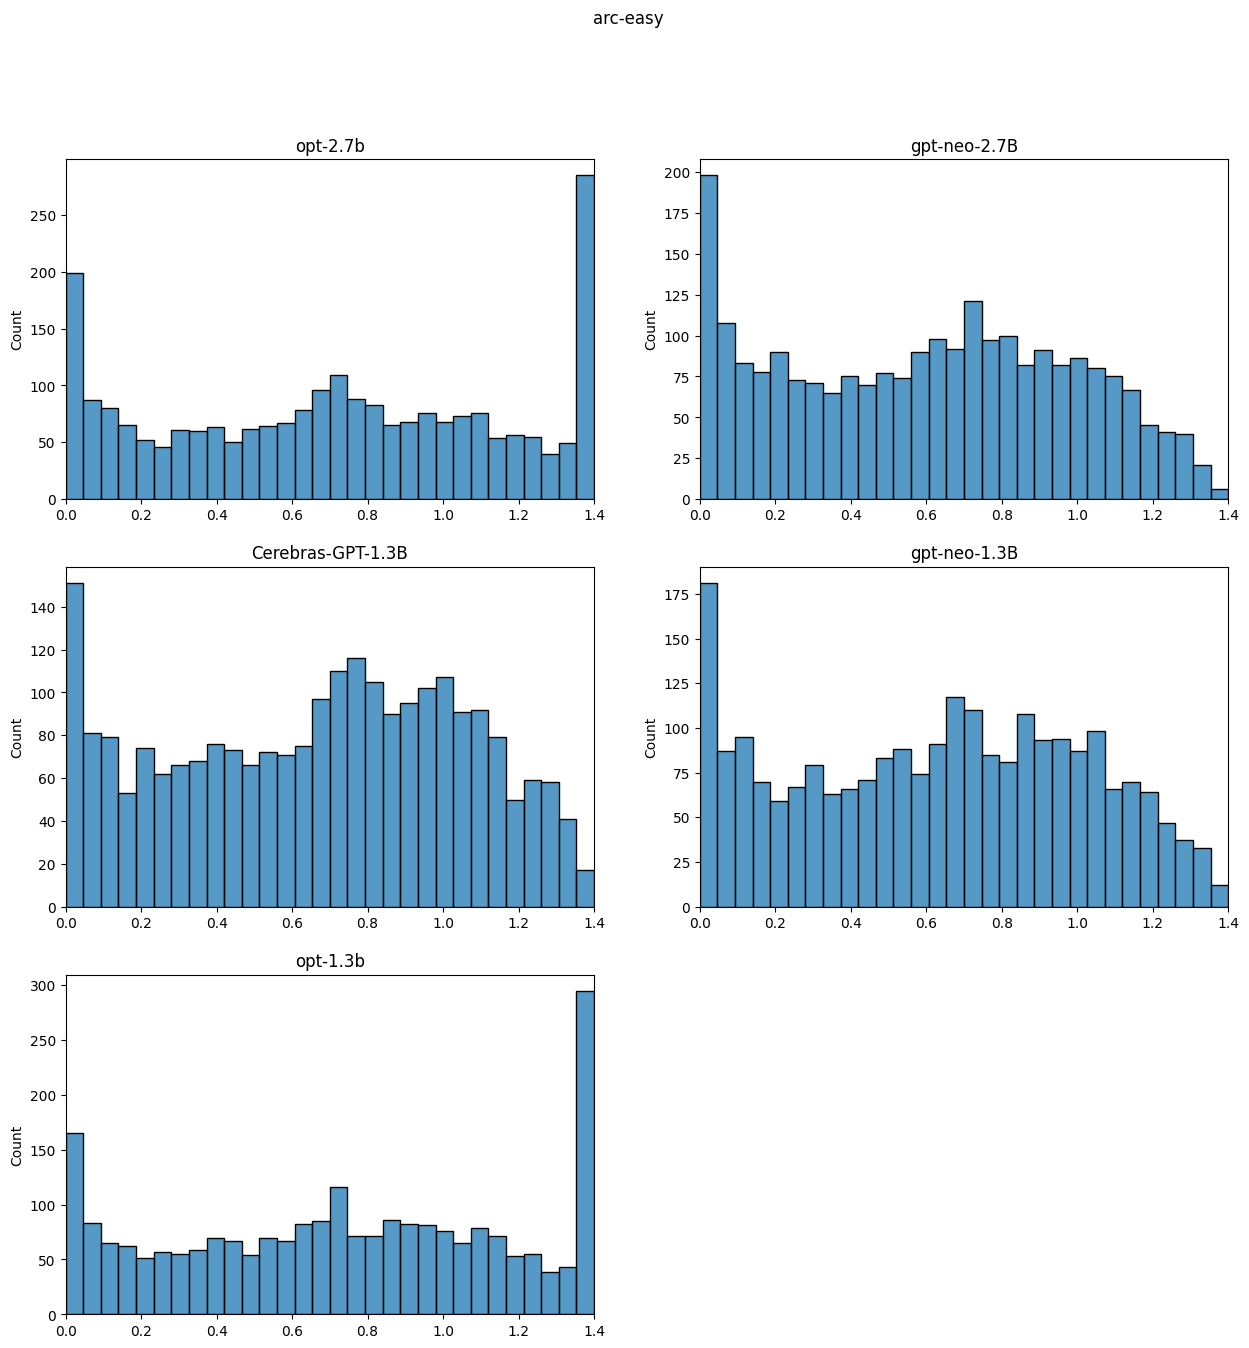

opt-2.7b
gpt-neo-2.7B
Cerebras-GPT-1.3B
gpt-neo-1.3B
opt-1.3b


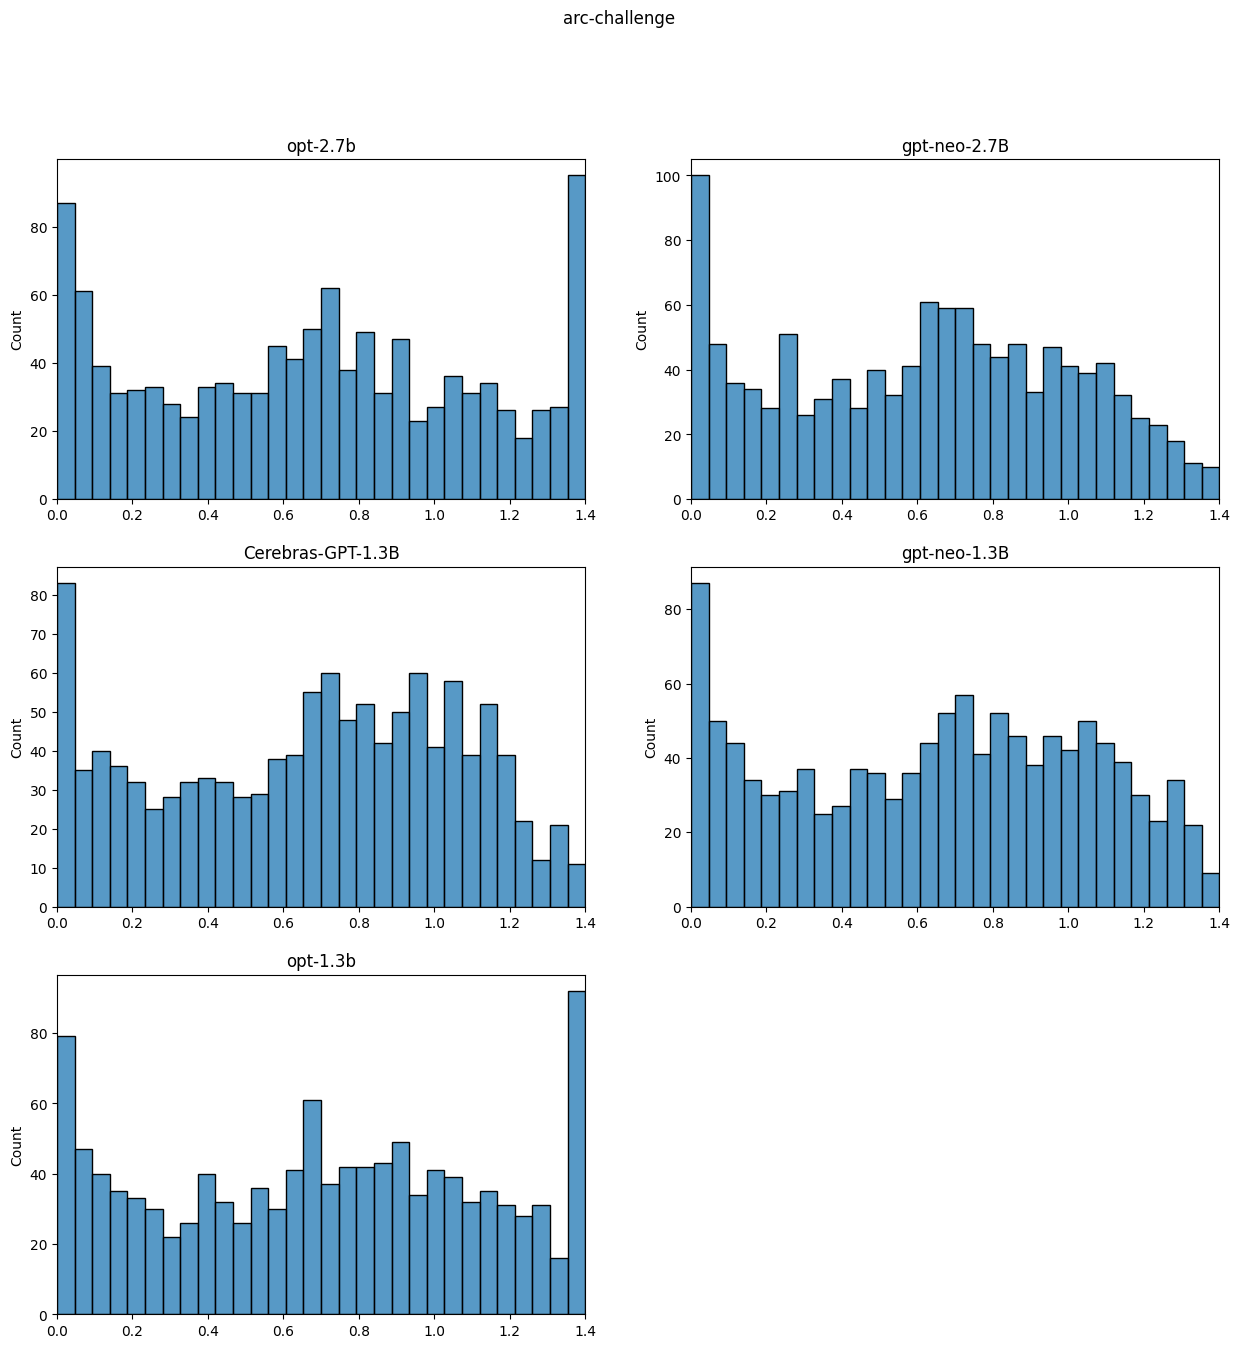

In [58]:
entropies = []

for dataset in hf_res['opt-1.3b']:
    plt.figure(figsize=(15, 15))
    plt.suptitle(dataset[12:-5])
    
    for idx, model in enumerate(hf_res, 1):
        predictions = []
        print(model)
        entr = calc_entropy(hf_res[model][dataset])
        plt.subplot(3, 2, idx)
        plt.title(model)
        sns.histplot(entr, bins=30, kde=False, stat='count', element='bars', binrange=(0, 1.4))
        plt.xlim(0, 1.4)
    plt.show()

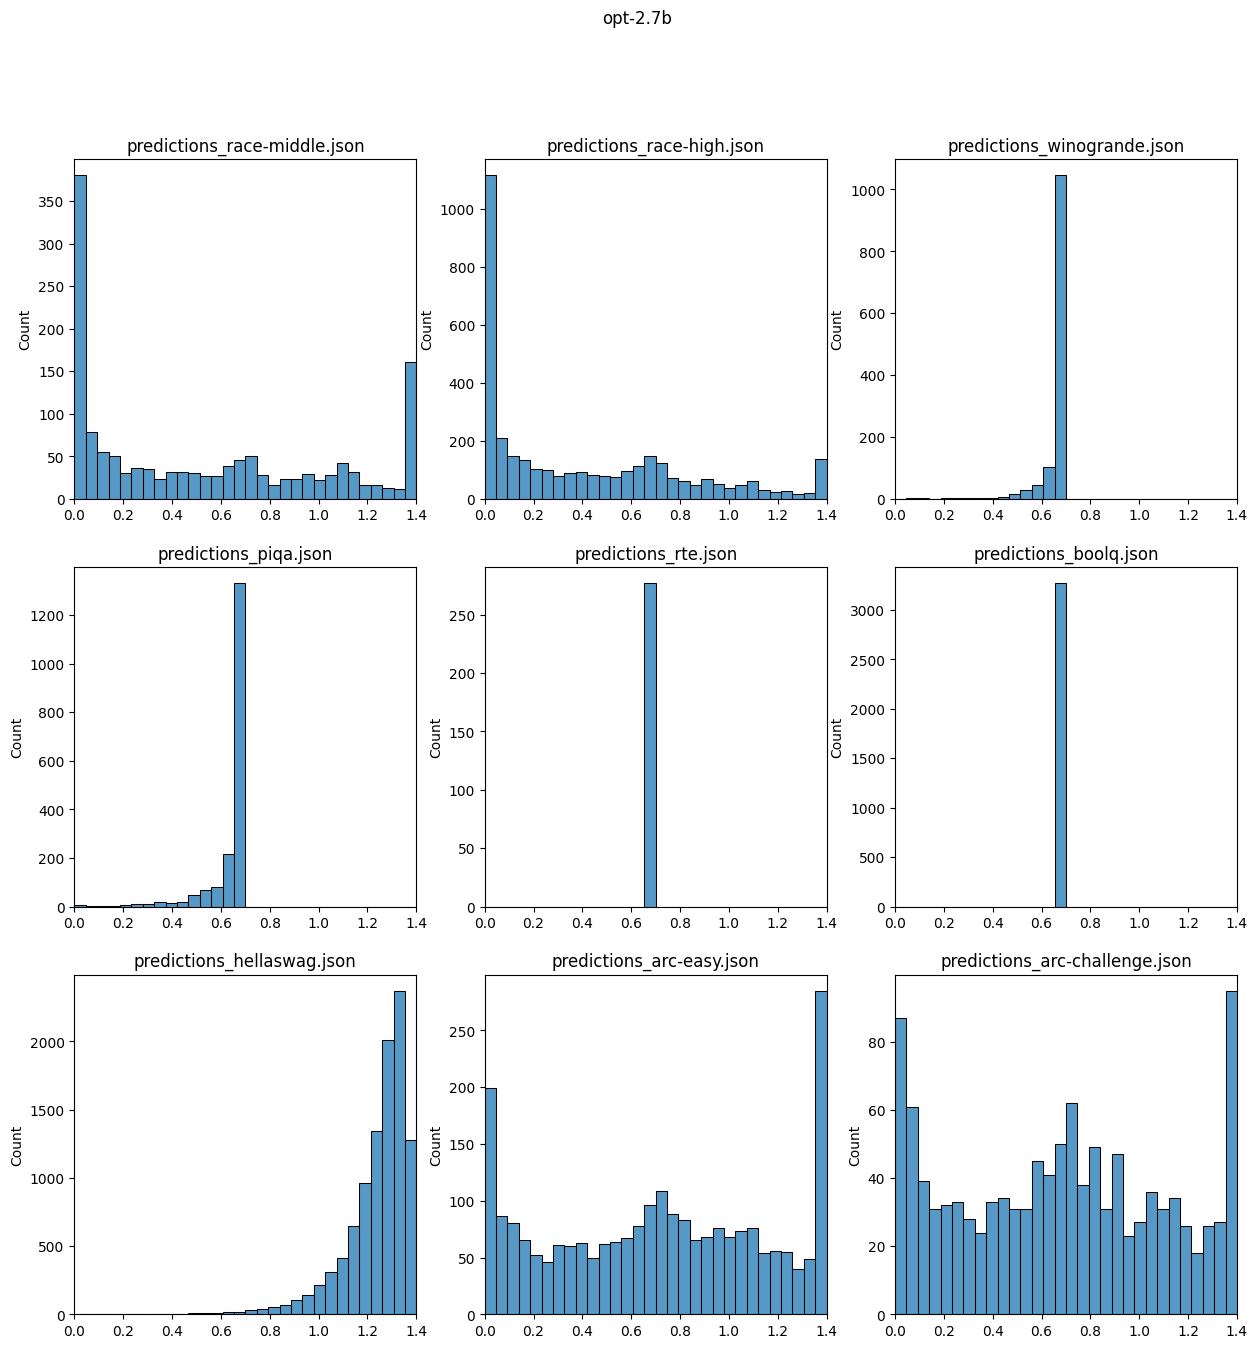

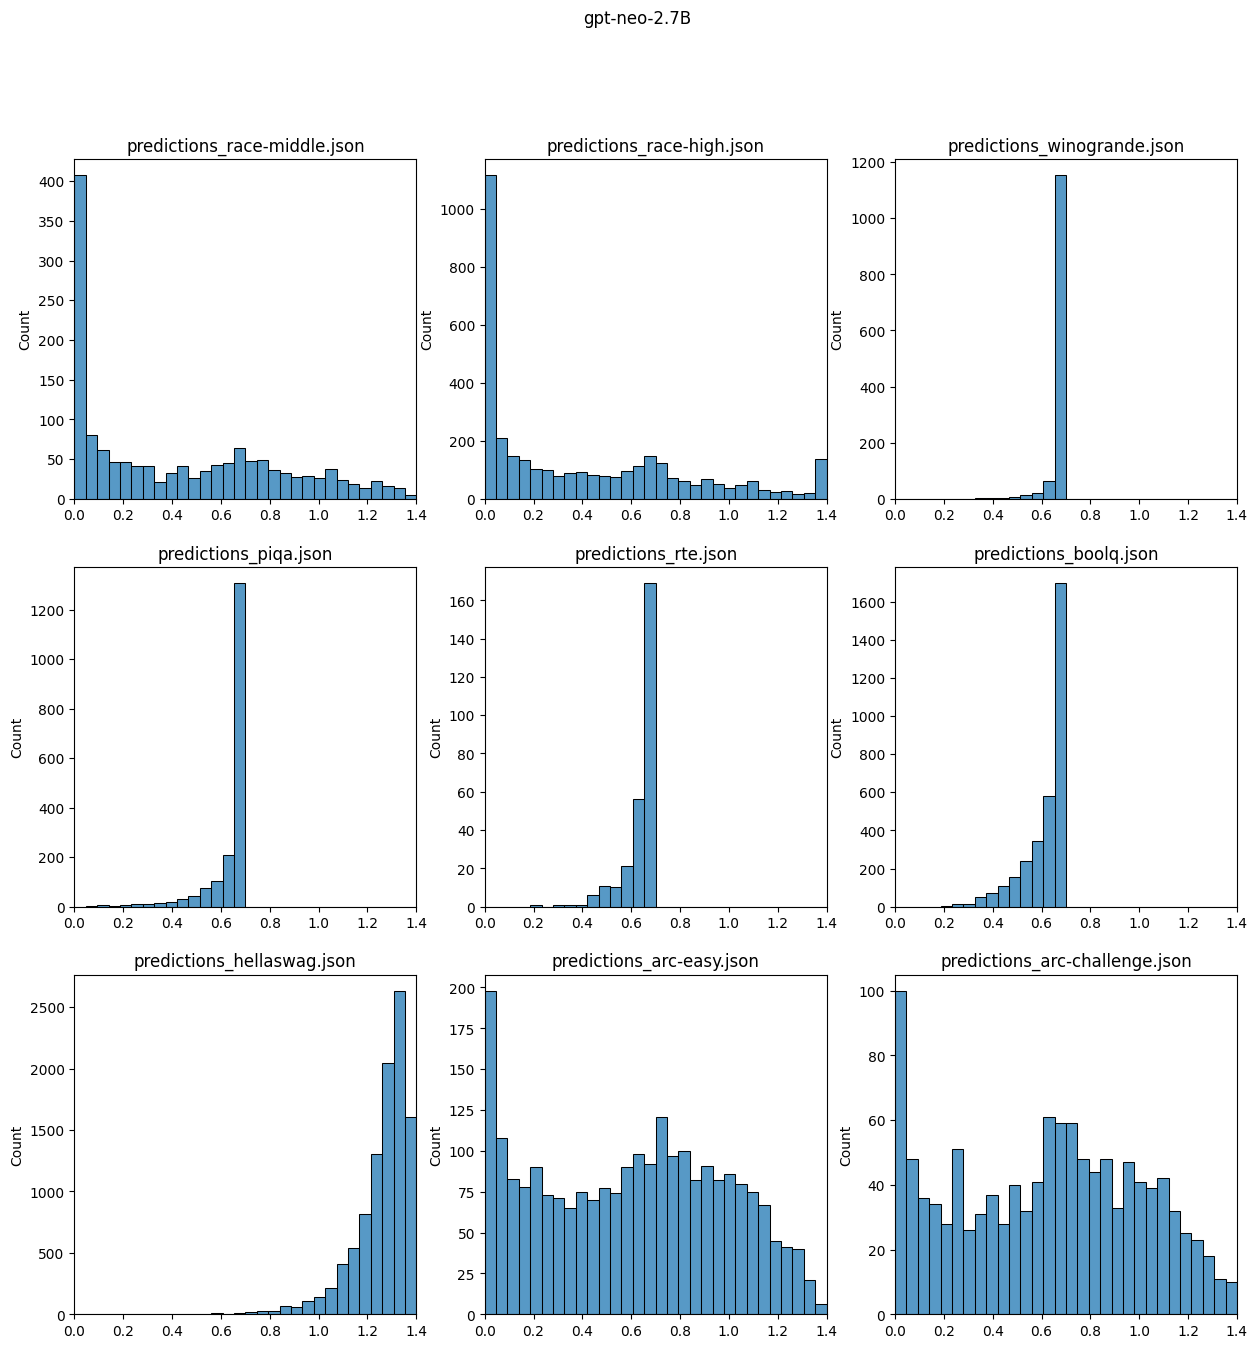

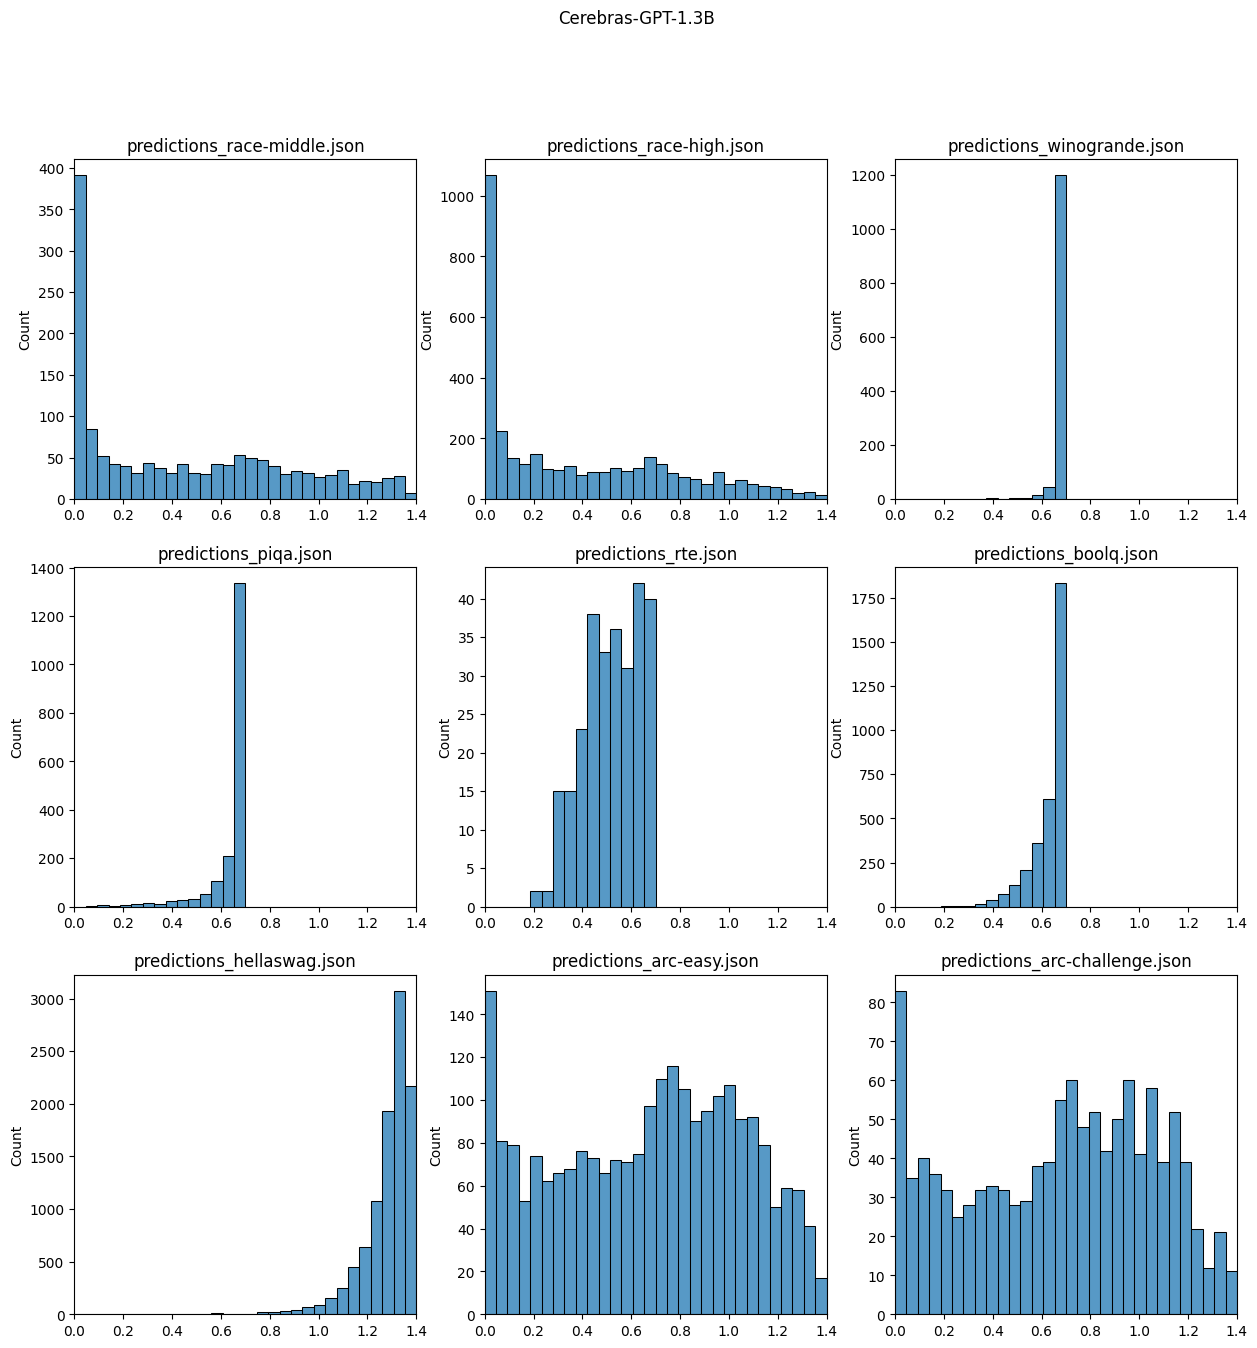

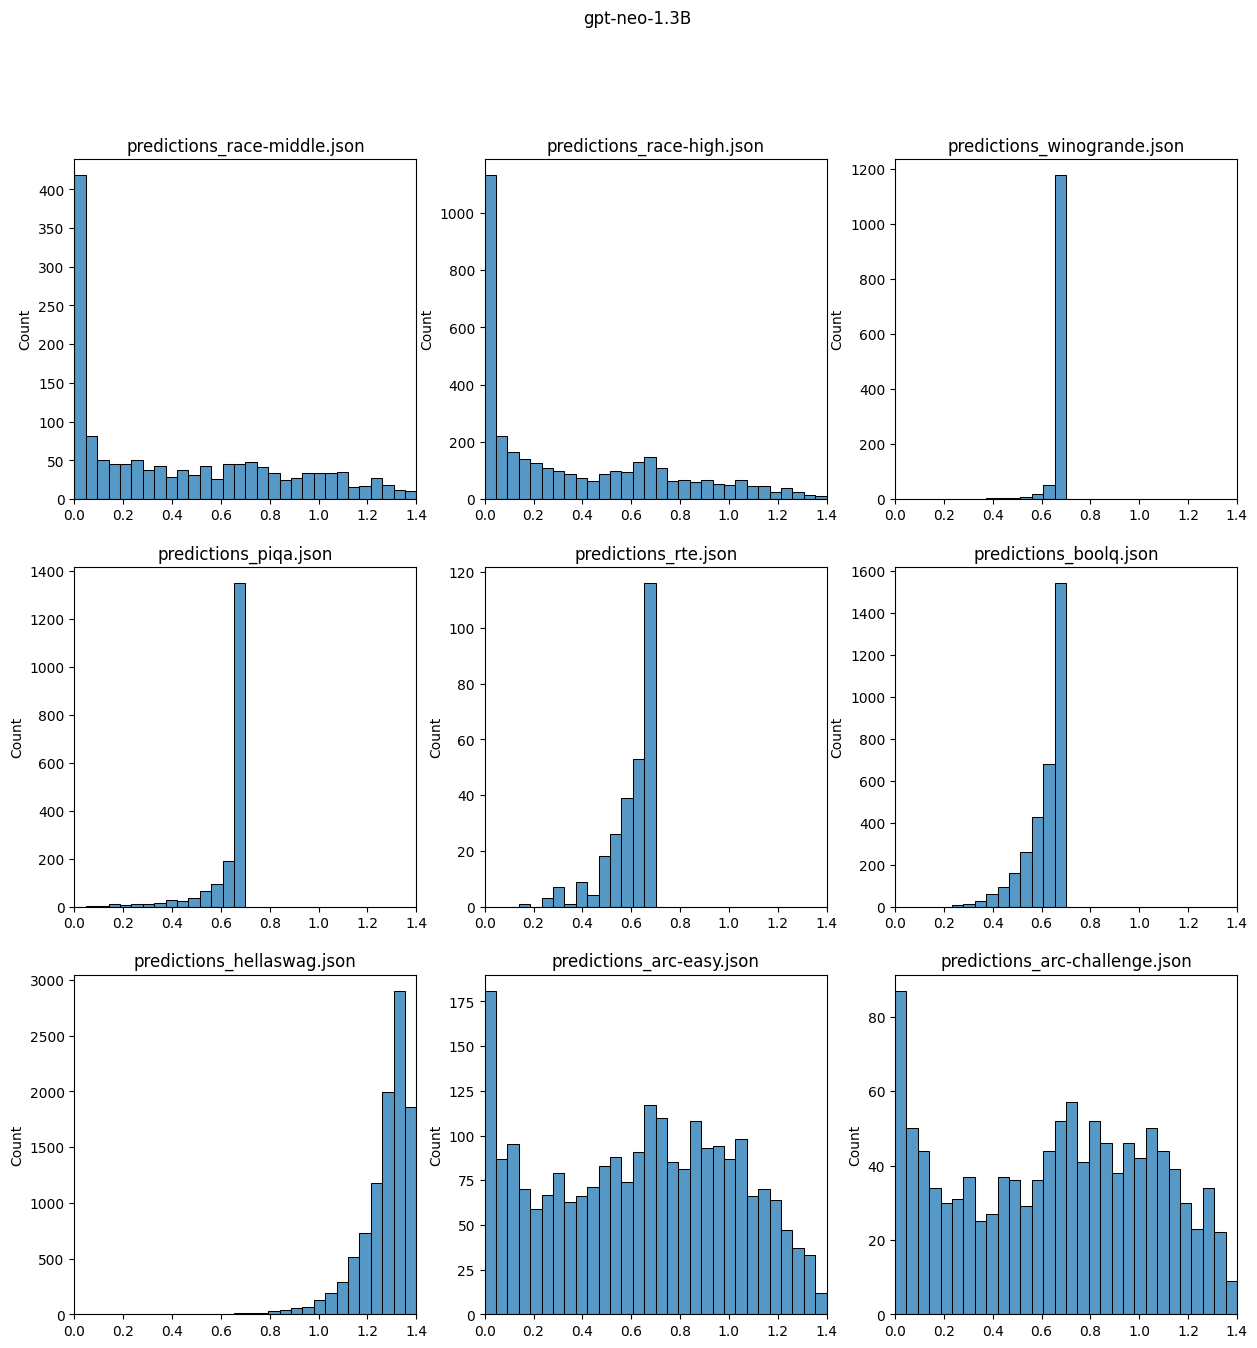

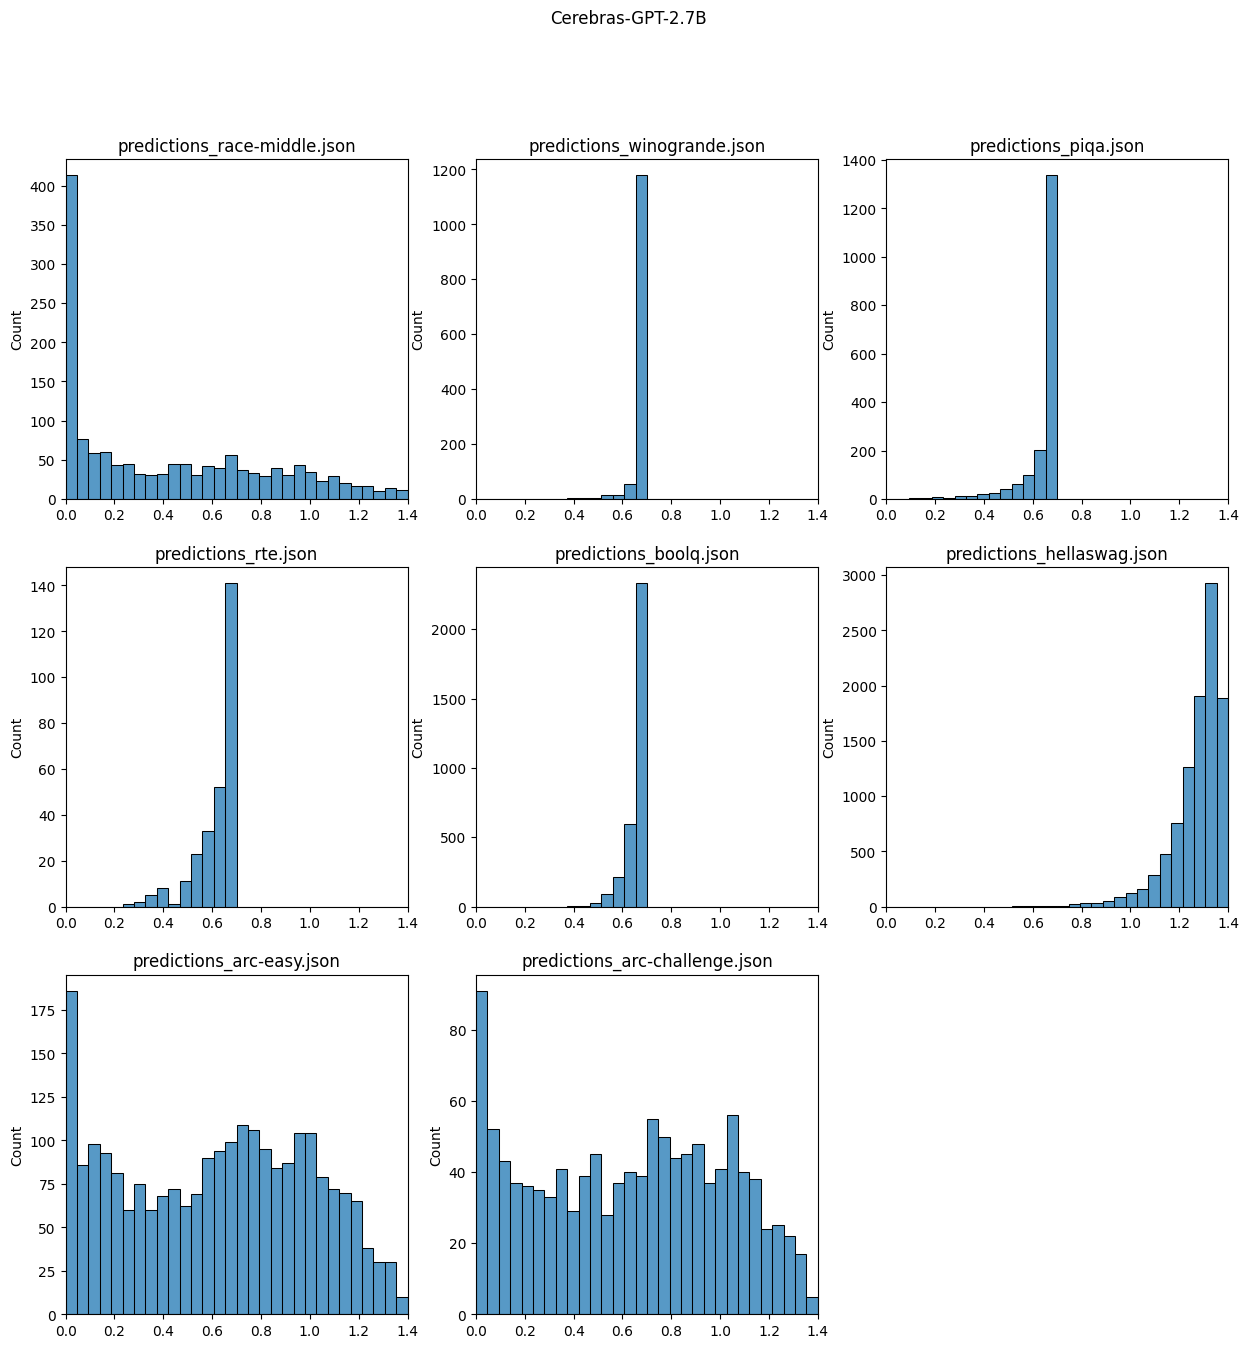

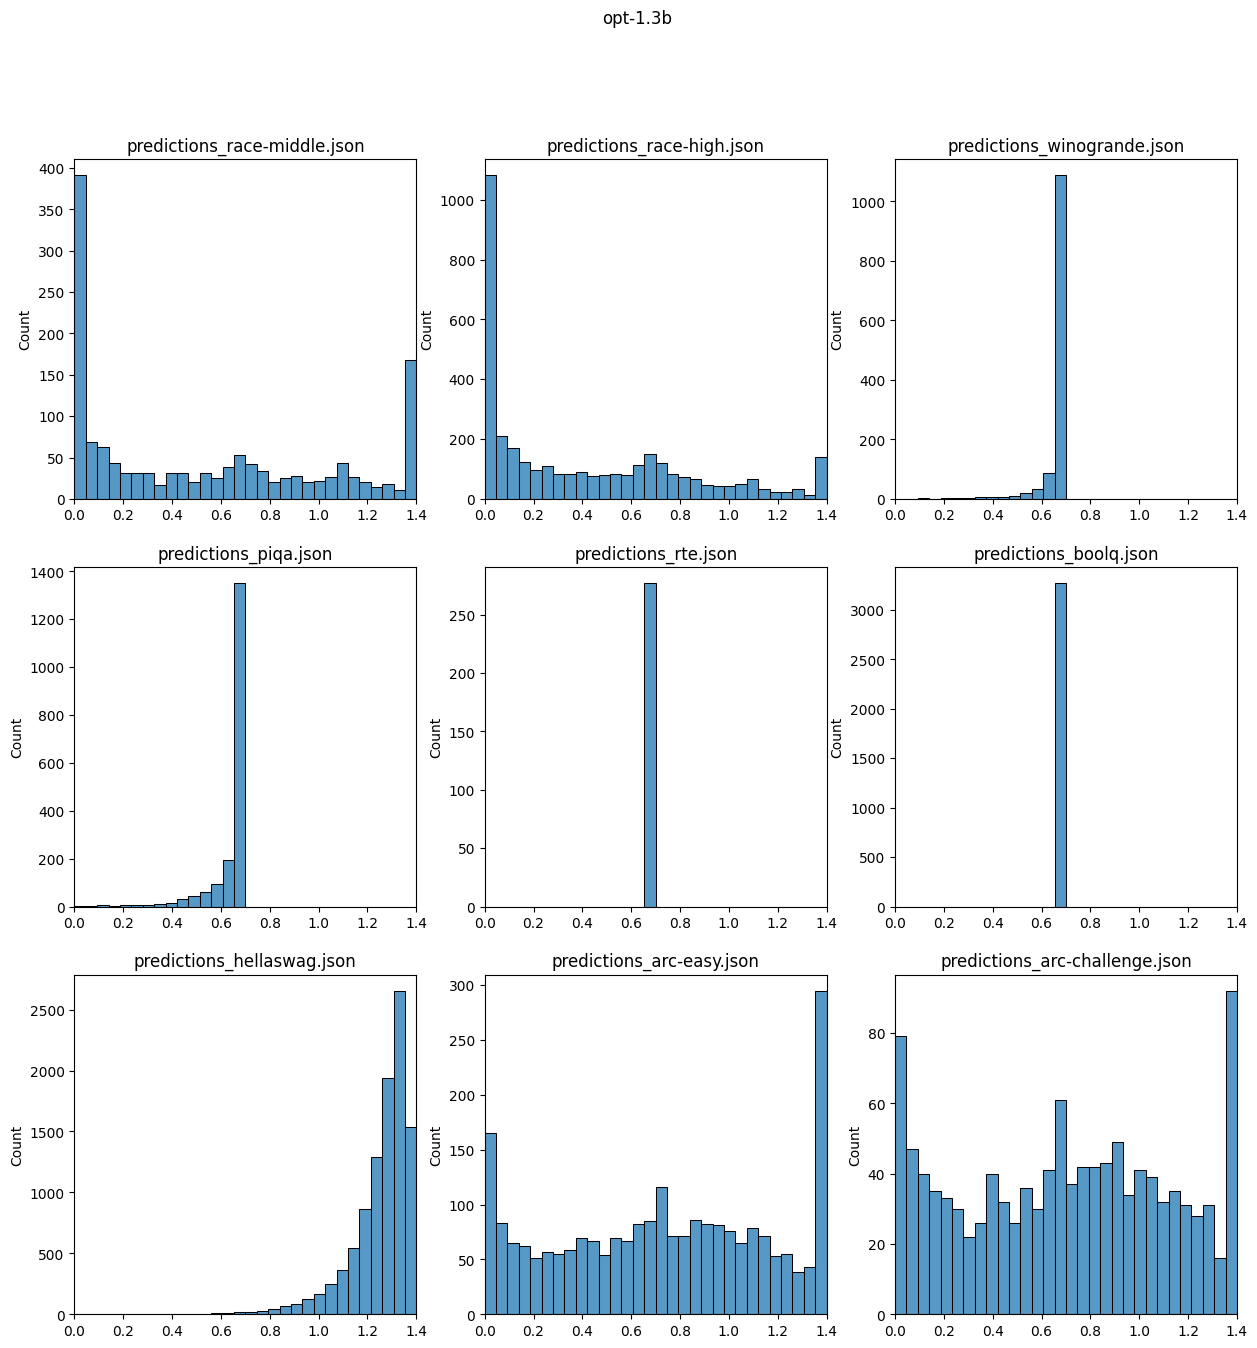

In [42]:
entropies = []

for model in hf_res:
    plt.figure(figsize=(15, 15))
    plt.suptitle(model)
    for idx, dataset in enumerate(hf_res[model], 1):
        predictions = []
        entr = calc_entropy(hf_res[model][dataset])
        plt.subplot(3, 3, idx)
        plt.title(dataset)
        sns.histplot(entr, bins=30, kde=False, stat='count', element='bars', binrange=(0, 1.4))
        plt.xlim(0, 1.4)
    plt.show()

In [407]:
def evaluate_with_entr(*predictions, T=1.0, key='acc_norm_ans_ctx'):
    if key not in predictions[0].columns:
        key = 'acc_norm_tokens'
    cur_pred = pd.Series(deepcopy(predictions[0][key].to_dict())).apply(lambda x: [0 for _ in x])
    for prediction in predictions:
        for i, pred in enumerate(prediction[key]):
            sm = softmax([x / T for x in pred])
            entr = entropy(sm)
            for j in range(len(cur_pred[i])):
                cur_pred[i][j] += (1.4 - entr) * sm[j]
    return (cur_pred.apply(np.argmax) == predictions[0]['target_index']).mean()

In [408]:
def evaluate_with_sm(*predictions, T=1.0, key='acc_norm_ans_ctx'):
    if key not in predictions[0].columns:
        key = 'acc_norm_tokens'
    cur_pred = pd.Series(deepcopy(predictions[0][key].to_dict())).apply(lambda x: [0 for _ in x])
    for prediction in predictions:
        for i, pred in enumerate(prediction[key]):
            sm = softmax([x / T for x in pred])
            for j in range(len(cur_pred[i])):
                cur_pred[i][j] += sm[j]
    return (cur_pred.apply(np.argmax) == predictions[0]['target_index']).mean()

In [357]:
(predictions[1].acc_norm_ans_ctx.apply(np.argmax) == predictions[1]['target_index']).mean()

0.34812286689419797

In [135]:
# for model in expert_set:
#     predictions.append(hf_res[model][dataset])
((predictions[1].acc_norm_ans_ctx.apply(np.argmax) == predictions[0]['target_index']) |\
 (predictions[0].acc_norm_ans_ctx.apply(np.argmax) == predictions[0]['target_index'])).mean()

0.3575085324232082

In [145]:
predictions[1].acc_norm_ans_ctx.apply(softmax)

0       [0.08564214707390852, 0.5810615931796712, 0.03...
1       [0.14982627000789142, 0.22069116440880243, 0.6...
2       [0.10341449163684739, 0.7727940495337238, 0.11...
3       [0.05563000967222663, 0.1780969404150264, 0.43...
4       [0.02130246074122196, 0.023381250737110122, 0....
                              ...                        
1167    [0.10640966895317751, 0.022370653052561397, 0....
1168    [0.9147719542734567, 0.02316815941311905, 0.06...
1169    [0.521278040945467, 0.47868980529188815, 4.261...
1170    [0.060119045053589976, 0.05817631555002914, 0....
1171    [9.78112055392667e-05, 0.0011363331890638598, ...
Name: acc_norm_ans_ctx, Length: 1172, dtype: object

In [144]:
predictions[0].acc_norm_ans_ctx.apply(softmax)

0       [3.6869847816775863e-06, 0.9998355810640935, 7...
1       [8.871094828548975e-07, 1.8572360088047564e-06...
2       [4.389993015927148e-09, 0.9999999943964775, 1....
3       [1.3901069268970706e-05, 0.013301707567152678,...
4       [9.444367005929306e-09, 5.767321010733338e-09,...
                              ...                        
1167    [7.932470142120668e-07, 8.606988818788786e-09,...
1168    [0.999999990285216, 6.03336667881956e-09, 3.68...
1169    [0.4166957884973926, 0.5833042114481323, 1.801...
1170    [6.69537905179647e-05, 6.317093808722504e-05, ...
1171    [4.08484278708954e-16, 3.1294985957128426e-13,...
Name: acc_norm_ans_ctx, Length: 1172, dtype: object

In [166]:
(predictions[0].acc_norm_ans_ctx
 .apply(np.argmax) == predictions[0]['target_index']).mean()

0.34812286689419797

In [164]:
T = 10
((
    predictions[1].acc_norm_ans_ctx.apply(lambda x: [t / sum(x) for t in x]) + 
    predictions[0].acc_norm_ans_ctx.apply(lambda x: [t / sum(x) for t in x])
)
 .apply(lambda x: [x[i] + x[len(x)//2 + i] for i in range(len(x)//2)])
 .apply(np.argmax) == predictions[0]['target_index']).mean()

0.3447098976109215

In [163]:
T = 10
((
    predictions[1].acc_norm_ans_ctx.apply(lambda x: softmax([t / T for t in x])) + 
    predictions[0].acc_norm_ans_ctx.apply(lambda x: softmax([t / T for t in x]))
)
 .apply(lambda x: [x[i] + x[len(x)//2 + i] for i in range(len(x)//2)])
 .apply(np.argmax) == predictions[0]['target_index']).mean()

0.2832764505119454

In [404]:
from collections import defaultdict
from tqdm.notebook import tqdm

evaluation_results = []
temperatures = [0.01, 0.1, 0.5, 0.7, 1., 2., 5., 10., 20., 50.,]

for expert_set in tqdm(expert_sets):
    for dataset in hf_res['opt-1.3b'].keys():
        predictions = []
        for model in expert_set:
            predictions.append(hf_res[model][dataset])
        for temperature in temperatures:
            metric = evaluate_with_sm(*predictions, T=temperature)
            evaluation_results.append(dict(
                model='+'.join(expert_set),
                dataset=dataset[12:-5],
                metric=metric,
                n_models=len(expert_set),
                temperature=temperature
            ))

  0%|          | 0/10 [00:00<?, ?it/s]

In [405]:
temp_ensembles = pd.DataFrame(evaluation_results)

In [406]:
temp_ensembles[temp_ensembles.n_models>1].groupby('temperature').metric.mean()

temperature
0.01     0.505377
0.10     0.508386
0.50     0.508886
0.70     0.508861
1.00     0.508863
2.00     0.508678
5.00     0.508466
10.00    0.508714
20.00    0.508535
50.00    0.508656
Name: metric, dtype: float64

In [371]:
temp_ensembles[temp_ensembles.n_models==1].metric.mean()

0.3665039876957589

In [ ]:
temp_ensembles[temp_ensembles.n_models>1].groupby('temperature').metric.mean()

In [ ]:
pd.DataFrame(evaluation_results)

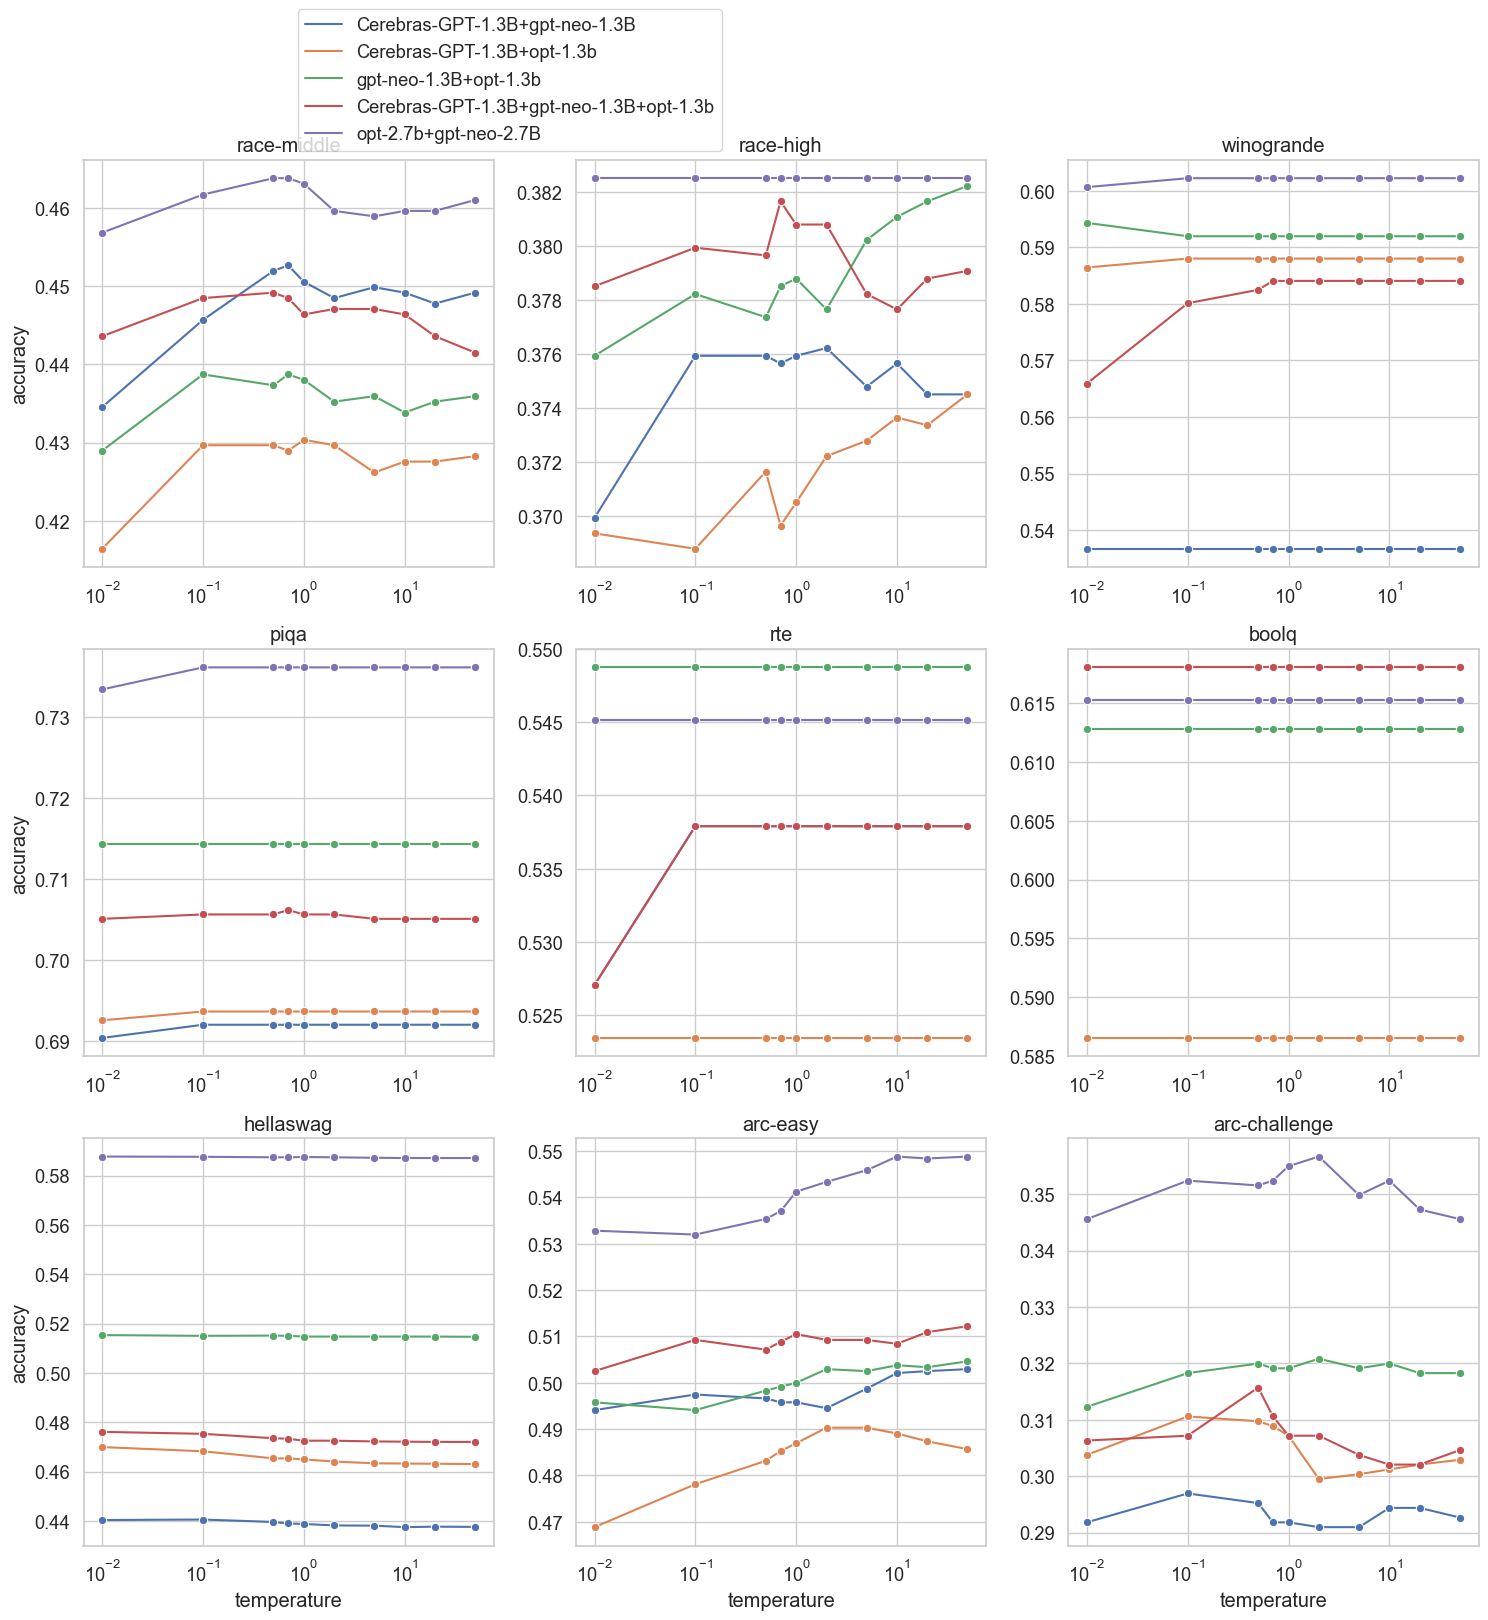

In [409]:
df = pd.DataFrame(evaluation_results)
datasets = df.dataset.unique()

sns.set(font_scale=1.2)
sns.set_style('whitegrid')
plt.figure(figsize=(18, 18))
for idx, dataset in enumerate(datasets, 1):
    plt.subplot(3, 3, idx)
    plt.title(dataset)
    sns.lineplot(data=df[(df.dataset==dataset)&(df.n_models>1)],
                 x="temperature", y="metric", hue="model", marker='o', legend=(idx==1))
    if idx == 1:
        plt.legend(bbox_to_anchor=(0.5, 1.))
    plt.xscale('log')
    if idx % 3 == 1:
        plt.ylabel('accuracy')
    else:
        plt.ylabel('')
    if idx <= 6:
        plt.xlabel('')
# plt.tight_layout()
# plt.figlegend(labels=df[(df.dataset==dataset)&(df.n_models>1)].model.unique(),
# loc = 'lower center', ncol=5, labelspacing=0.)

In [320]:
from collections import defaultdict
from tqdm.notebook import tqdm

evaluation_results = []
temperatures = [0.01, 0.1, 0.5, 0.7, 1., 2., 5., 10., 20., 50.]

for expert_set in tqdm(expert_sets):
    for dataset in hf_res['opt-1.3b'].keys():
        predictions = []
        for model in expert_set:
            predictions.append(hf_res[model][dataset])
        for temperature in temperatures:
            metric = evaluate_with_entr(*predictions, T=temperature)
            evaluation_results.append(dict(
                model='+'.join(expert_set),
                dataset=dataset[12:-5],
                metric=metric,
                n_models=len(expert_set),
                temperature=temperature
            ))

  0%|          | 0/10 [00:00<?, ?it/s]

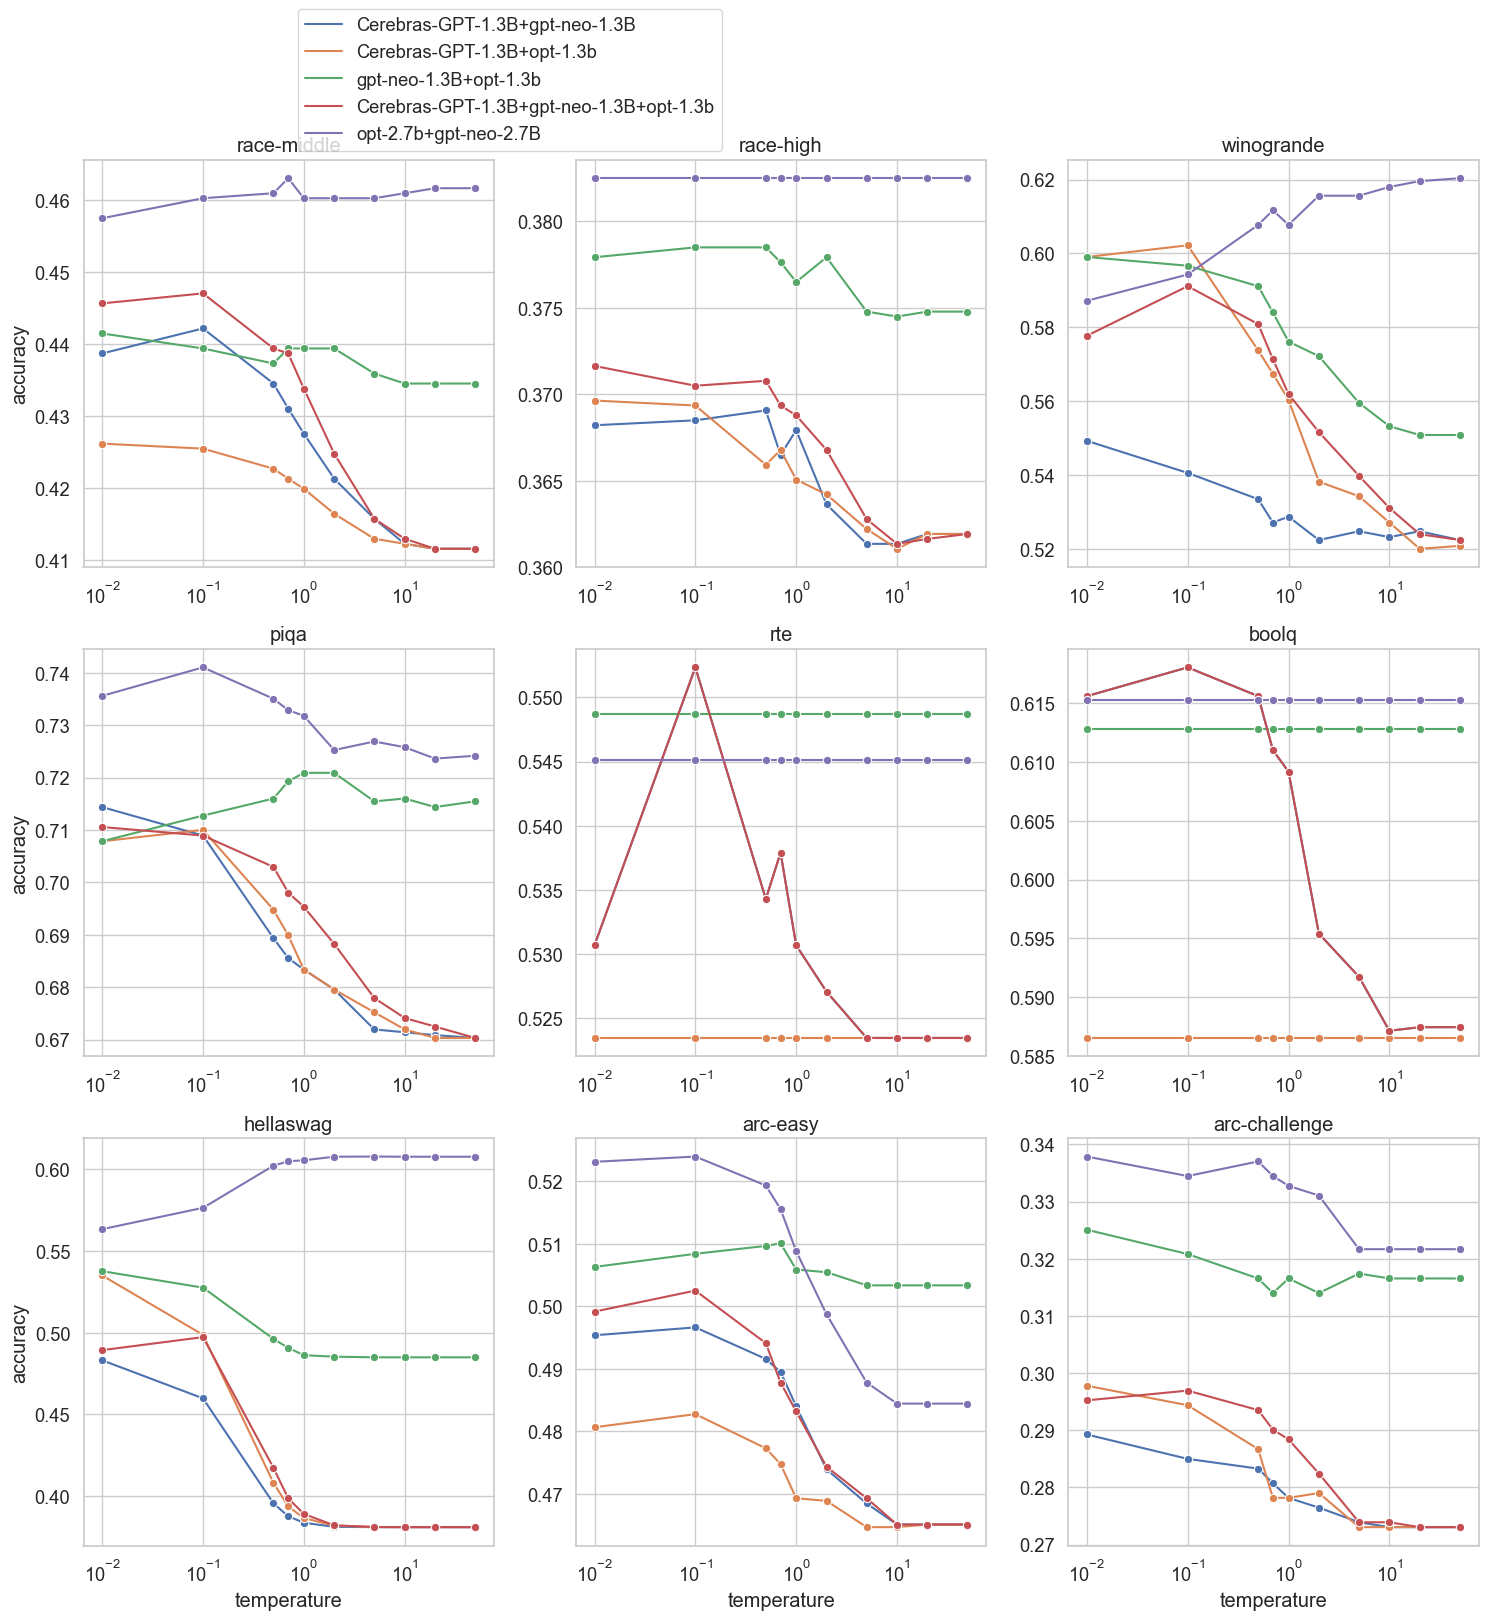

In [322]:
df = pd.DataFrame(evaluation_results)
datasets = df.dataset.unique()

sns.set(font_scale=1.2)
sns.set_style('whitegrid')
plt.figure(figsize=(18, 18))
for idx, dataset in enumerate(datasets, 1):
    plt.subplot(3, 3, idx)
    plt.title(dataset)
    sns.lineplot(data=df[(df.dataset==dataset)&(df.n_models>1)],
                 x="temperature", y="metric", hue="model", marker='o', legend=(idx==1))
    if idx == 1:
        plt.legend(bbox_to_anchor=(0.5, 1.))
    plt.xscale('log')
    if idx % 3 == 1:
        plt.ylabel('accuracy')
    else:
        plt.ylabel('')
    if idx <= 6:
        plt.xlabel('')

# plt.tight_layout()

In [307]:
def _evaluate_with_entr(*predictions, T=1.0, key='acc_norm_ans_ctx'):
    if key not in predictions[0].columns:
        key = 'acc_norm_tokens'
    cur_pred = pd.Series(deepcopy(predictions[0][key].to_dict())).apply(lambda x: [0 for _ in x])
    for prediction in predictions:
        for i, pred in enumerate(prediction[key]):
            sm = softmax([x / T for x in pred])
            entr = entropy(sm)
            for j in range(len(cur_pred[i])):
                cur_pred[i][j] += entr * sm[j]
    return (cur_pred.apply(np.argmax) == predictions[0]['target_index']).mean()

In [398]:
def evaluate_entropy_voting(*predictions, T=1.0, key='acc_norm_ans_ctx'):
    if key not in predictions[0].columns:
        key = 'acc_norm_tokens'
    cur_pred = pd.Series(deepcopy(predictions[0][key].to_dict())).apply(lambda x: [0 for _ in x])
    best_entr = np.ones(predictions[0].shape[0]) * 100
    for prediction in predictions:
        for i, pred in enumerate(prediction[key]):
            sm = softmax(pred)
            entr = entropy(sm)
            if entr > best_entr[i]:
                continue
            best_entr[i] = entr
            for j in range(len(cur_pred[i])):
                cur_pred[i][j] = pred[j]
    return (cur_pred.apply(np.argmax) == predictions[0]['target_index']).mean()

In [399]:
from collections import defaultdict


evaluation_results = defaultdict(list)
evaluation_funcs = dict(
    entropy=evaluate_entropy_voting,
)

for expert_set in expert_sets:
    for dataset in hf_res['opt-1.3b'].keys():
        predictions = []
        for model in expert_set:
            predictions.append(hf_res[model][dataset])
        for name, evaluation_func in evaluation_funcs.items():
            metric = evaluation_func(*predictions)
            evaluation_results[name].append(dict(
                model='+'.join(expert_set),
                dataset=dataset[12:-5],
                metric=metric,
                n_models=len(expert_set)
            ))

In [400]:
pd.DataFrame(evaluation_results['entropy']).pivot('model', 'dataset', 'metric')

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/2950319480.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pd.DataFrame(evaluation_results['entropy']).pivot('model', 'dataset', 'metric')


dataset,arc-challenge,arc-easy,boolq,hellaswag,piqa,race-high,race-middle,rte,winogrande
model,,,,,,,,,
Cerebras-GPT-1.3B,0.273038,0.465067,0.586544,0.381099,0.669750,0.361921,0.411560,0.523466,0.519337
Cerebras-GPT-1.3B+gpt-neo-1.3B,0.290102,0.494108,0.618043,0.455686,0.692057,0.372784,0.441504,0.537906,0.536701
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b,0.309727,0.495791,0.618043,0.507269,0.698585,0.367925,0.439415,0.537906,0.584846
Cerebras-GPT-1.3B+opt-1.3b,0.307167,0.477273,0.586544,0.508365,0.693689,0.368496,0.430362,0.523466,0.588003
gpt-neo-1.3B,0.316553,0.503367,0.612844,0.484963,0.714908,0.374786,0.434540,0.548736,0.549329
gpt-neo-1.3B+opt-1.3b,0.312287,0.493687,0.612844,0.524597,0.714363,0.375929,0.438022,0.548736,0.591949
gpt-neo-2.7B,0.348123,0.541667,0.615291,0.561840,0.731774,0.382504,0.453343,0.545126,0.577743
opt-1.3b,0.323379,0.408249,0.621713,0.538936,0.707291,0.368210,0.401114,0.527076,0.595107
opt-2.7b,0.316553,0.429293,0.621713,0.607648,0.719804,0.382504,0.422702,0.527076,0.621152


In [442]:
from collections import defaultdict


evaluation_results = defaultdict(list)
evaluation_funcs = dict(
    naive=evaluate_on_dataset,
    softmax=evaluate_with_sm,
    entropy=evaluate_with_entr,
    voting_entropy=evaluate_entropy_voting,
)

for expert_set in expert_sets:
    for dataset in hf_res['opt-1.3b'].keys():
        predictions = []
        for model in expert_set:
            predictions.append(hf_res[model][dataset])
        for name, evaluation_func in evaluation_funcs.items():
            if name != 'naive': 
                metric = evaluation_func(*predictions, T=1)
            else:
                metric = evaluation_func(*predictions)
            
            evaluation_results[name].append(dict(
                model='+'.join(expert_set),
                dataset=dataset[12:-5],
                metric=metric,
                n_models=len(expert_set)
            ))

In [420]:
(pd.DataFrame(evaluation_results['voting_entropy']).pivot('model', 'dataset', 'metric') -\
pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric')) /\
pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric') * 100

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/288286583.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (pd.DataFrame(evaluation_results['voting_entropy']).pivot('model', 'dataset', 'metric') -\
/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/288286583.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric')) /\
/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/288286583.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric') * 100


dataset,arc-challenge,arc-easy,boolq,hellaswag,piqa,race-high,race-middle,rte,winogrande
model,,,,,,,,,
Cerebras-GPT-1.3B,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Cerebras-GPT-1.3B+gpt-neo-1.3B,-0.874636,-1.921470,0.0,4.142012,0.000000,-0.458015,-1.552795,0.0,0.000000
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b,1.680672,-3.363413,0.0,7.468354,-0.925926,-2.794562,-0.629921,0.0,0.135135
Cerebras-GPT-1.3B+opt-1.3b,0.558659,-1.903114,0.0,9.784946,0.000000,-1.603053,0.324675,0.0,0.000000
gpt-neo-1.3B,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
gpt-neo-1.3B+opt-1.3b,-1.347709,-2.250000,0.0,1.934985,0.000000,-1.571856,0.318979,0.0,0.000000
gpt-neo-2.7B,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
opt-1.3b,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
opt-2.7b,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [422]:
(pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric') -\
pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric')) /\
pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric') * 100

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/3662338447.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric') -\
/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/3662338447.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric')) /\
/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/3662338447.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric') * 100


dataset,arc-challenge,arc-easy,boolq,hellaswag,piqa,race-high,race-middle,rte,winogrande
model,,,,,,,,,
Cerebras-GPT-1.3B,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Cerebras-GPT-1.3B+gpt-neo-1.3B,1.436782,-1.269036,0.0,0.678119,0.000000,0.380228,-0.625000,0.0,0.000000
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b,0.833333,-0.743802,0.0,0.691389,0.077101,0.376223,1.397516,0.0,-0.680272
Cerebras-GPT-1.3B+opt-1.3b,1.648352,-1.760563,0.0,1.105912,0.000000,-1.550388,0.162075,0.0,0.000000
gpt-neo-1.3B,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
gpt-neo-1.3B+opt-1.3b,0.536193,-2.214651,0.0,0.077340,0.000000,-0.982615,0.476190,0.0,0.000000
gpt-neo-2.7B,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
opt-1.3b,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
opt-2.7b,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [330]:
pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric')

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/2289386912.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric')


dataset,arc-challenge,arc-easy,boolq,hellaswag,piqa,race-high,race-middle,rte,winogrande
model,,,,,,,,,
Cerebras-GPT-1.3B,0.273038,0.465067,0.586544,0.381099,0.669750,0.361921,0.411560,0.523466,0.519337
Cerebras-GPT-1.3B+gpt-neo-1.3B,0.290102,0.494108,0.614985,0.467437,0.709467,0.368210,0.441504,0.541516,0.546961
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b,0.292662,0.494529,0.614985,0.498905,0.711643,0.369640,0.447075,0.541516,0.588792
Cerebras-GPT-1.3B+opt-1.3b,0.291809,0.481061,0.586544,0.510755,0.708379,0.367925,0.428273,0.523466,0.599842
gpt-neo-1.3B,0.316553,0.503367,0.612844,0.484963,0.714908,0.374786,0.434540,0.548736,0.549329
gpt-neo-1.3B+opt-1.3b,0.322526,0.512205,0.612844,0.531169,0.711643,0.377644,0.443593,0.548736,0.600631
gpt-neo-2.7B,0.348123,0.541667,0.615291,0.561840,0.731774,0.382504,0.453343,0.545126,0.577743
opt-1.3b,0.323379,0.408249,0.621713,0.538936,0.707291,0.368210,0.401114,0.527076,0.595107
opt-2.7b,0.316553,0.429293,0.621713,0.607648,0.719804,0.382504,0.422702,0.527076,0.621152


In [331]:
pd.DataFrame(evaluation_results['entropy']).pivot('model', 'dataset', 'metric') - \
pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric')

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/3261663330.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pd.DataFrame(evaluation_results['entropy']).pivot('model', 'dataset', 'metric') - \
/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/3261663330.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric')


dataset,arc-challenge,arc-easy,boolq,hellaswag,piqa,race-high,race-middle,rte,winogrande
model,,,,,,,,,
Cerebras-GPT-1.3B,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Cerebras-GPT-1.3B+gpt-neo-1.3B,-0.007679,-0.007155,0.0,0.022306,0.016866,-0.006003,-0.006267,0.01444,0.003946
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b,-0.007679,-0.010522,0.0,0.025294,0.003808,-0.008005,0.004875,0.01444,0.007103
Cerebras-GPT-1.3B+opt-1.3b,-0.011092,-0.003788,0.0,0.035650,0.016322,-0.005146,-0.003482,0.00000,0.014207
gpt-neo-1.3B,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gpt-neo-1.3B+opt-1.3b,0.004266,0.003367,0.0,0.012946,-0.001632,-0.003431,0.002786,0.00000,0.004736
gpt-neo-2.7B,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
opt-1.3b,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
opt-2.7b,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [332]:
pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric') - \
pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric')

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/1967725948.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric') - \
/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/1967725948.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric')


dataset,arc-challenge,arc-easy,boolq,hellaswag,piqa,race-high,race-middle,rte,winogrande
model,,,,,,,,,
Cerebras-GPT-1.3B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Cerebras-GPT-1.3B+gpt-neo-1.3B,-0.002560,-0.009680,-0.003058,0.029875,0.017410,-0.006289,-0.006964,0.00361,0.010260
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b,-0.011945,-0.018519,-0.003058,0.026887,0.006529,-0.008862,0.004875,0.00361,0.004736
Cerebras-GPT-1.3B+opt-1.3b,-0.013652,-0.005471,0.000000,0.047700,0.014690,-0.006575,-0.000696,0.00000,0.011839
gpt-neo-1.3B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gpt-neo-1.3B+opt-1.3b,0.005973,0.007155,0.000000,0.016531,-0.002720,-0.004288,0.006964,0.00000,0.008682
gpt-neo-2.7B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
opt-1.3b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
opt-2.7b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [338]:
table

dataset,arc-challenge,arc-easy,boolq,hellaswag,piqa,race-high,race-middle,rte,winogrande
model,,,,,,,,,
Cerebras-GPT-1.3B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Cerebras-GPT-1.3B+gpt-neo-1.3B,-0.002560,-0.009680,-0.003058,0.029875,0.017410,-0.006289,-0.006964,0.00361,0.010260
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b,-0.011945,-0.018519,-0.003058,0.026887,0.006529,-0.008862,0.004875,0.00361,0.004736
Cerebras-GPT-1.3B+opt-1.3b,-0.013652,-0.005471,0.000000,0.047700,0.014690,-0.006575,-0.000696,0.00000,0.011839
gpt-neo-1.3B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gpt-neo-1.3B+opt-1.3b,0.005973,0.007155,0.000000,0.016531,-0.002720,-0.004288,0.006964,0.00000,0.008682
gpt-neo-2.7B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
opt-1.3b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
opt-2.7b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [340]:
table = pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric') - \
pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric')
table.columns.name = ''
table.index.name = ''
print(latex_with_color(table * 100))

\begin{tabular}{llllllllll}
 & arc-challenge & arc-easy & boolq & hellaswag & piqa & race-high & race-middle & rte & winogrande \\
 &  &  &  &  &  &  &  &  &  \\
Cerebras-GPT-1.3B & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 \\
Cerebras-GPT-1.3B+gpt-neo-1.3B & \textcolor{BrickRed}{-0.256} & \textcolor{BrickRed}{-0.968} & \textcolor{BrickRed}{-0.306} & \textcolor{ForestGreen}{2.987} & \textcolor{ForestGreen}{1.741} & \textcolor{BrickRed}{-0.629} & \textcolor{BrickRed}{-0.696} & \textcolor{ForestGreen}{0.361} & \textcolor{ForestGreen}{1.026} \\
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b & \textcolor{BrickRed}{-1.195} & \textcolor{BrickRed}{-1.852} & \textcolor{BrickRed}{-0.306} & \textcolor{ForestGreen}{2.689} & \textcolor{ForestGreen}{0.653} & \textcolor{BrickRed}{-0.886} & \textcolor{ForestGreen}{0.487} & \textcolor{ForestGreen}{0.361} & \textcolor{ForestGreen}{0.474} \\
Cerebras-GPT-1.3B+opt-1.3b & \textcolor{BrickRed}{-1.365} & \textcolor{BrickRed}{-0.547} & 0

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/3138569923.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  table = pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric') - \
/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/3138569923.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric')


In [433]:
table = (pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric') -\
pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric')) /\
pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric') * 100

table.columns.name = ''
table.index.name = ''
print(latex_with_color(table))

\begin{tabular}{llllllllll}
 & arc-challenge & arc-easy & boolq & hellaswag & piqa & race-high & race-middle & rte & winogrande \\
 &  &  &  &  &  &  &  &  &  \\
Cerebras-GPT-1.3B & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
Cerebras-GPT-1.3B+gpt-neo-1.3B & \textcolor{ForestGreen}{1.5} & \textcolor{BrickRed}{-1.3} & 0.0 & \textcolor{ForestGreen}{0.7} & 0.0 & \textcolor{ForestGreen}{0.4} & \textcolor{BrickRed}{-0.6} & 0.0 & 0.0 \\
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b & \textcolor{ForestGreen}{0.8} & \textcolor{BrickRed}{-0.7} & 0.0 & \textcolor{ForestGreen}{0.7} & \textcolor{ForestGreen}{0.1} & \textcolor{ForestGreen}{0.4} & \textcolor{ForestGreen}{1.4} & 0.0 & \textcolor{BrickRed}{-0.7} \\
Cerebras-GPT-1.3B+opt-1.3b & \textcolor{ForestGreen}{1.7} & \textcolor{BrickRed}{-1.7} & 0.0 & \textcolor{ForestGreen}{1.1} & 0.0 & \textcolor{BrickRed}{-1.5} & \textcolor{ForestGreen}{0.2} & 0.0 & 0.0 \\
gpt-neo-1.3B & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
gpt-neo-1.3

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/2359420856.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  table = (pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric') -\
/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/2359420856.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric')) /\
/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/2359420856.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric') * 100


In [438]:
beautiful_metrics(pd.DataFrame(evaluation_results['voting_entropy']).pivot('model', 'dataset', 'metric'))

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/3505424872.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  beautiful_metrics(pd.DataFrame(evaluation_results['voting_entropy']).pivot('model', 'dataset', 'metric'))


dataset,arc-challenge,arc-easy,boolq,hellaswag,piqa,race-high,race-middle,rte,winogrande
model,,,,,,,,,
Cerebras-GPT-1.3B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cerebras-GPT-1.3B+gpt-neo-1.3B,-8.355795,-1.839465,0.848303,-6.036961,-3.196347,-0.533944,1.602564,-1.973684,-2.298851
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b,-4.221636,-1.505017,-0.590261,-5.875831,-2.283105,-1.830664,1.121795,-1.973684,-1.724138
Cerebras-GPT-1.3B+opt-1.3b,-5.013193,2.624434,-5.656665,-5.672579,-1.923077,0.077640,4.568528,-0.684932,-1.193634
gpt-neo-1.3B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gpt-neo-1.3B+opt-1.3b,-3.430079,-1.923077,-1.426463,-2.660754,-0.076104,0.305111,0.801282,0.000000,-0.530504
gpt-neo-2.7B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
opt-1.3b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
opt-2.7b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [440]:
beautiful_metrics(pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric'))

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/4288695298.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  beautiful_metrics(pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric'))


dataset,arc-challenge,arc-easy,boolq,hellaswag,piqa,race-high,race-middle,rte,winogrande
model,,,,,,,,,
Cerebras-GPT-1.3B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cerebras-GPT-1.3B+gpt-neo-1.3B,-7.547170,0.083612,0.848303,-9.774127,-3.196347,-0.076278,3.205128,-1.973684,-2.298851
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b,-5.804749,1.923077,-0.590261,-12.416851,-1.369863,0.991609,1.762821,-1.973684,-1.856764
Cerebras-GPT-1.3B+opt-1.3b,-5.540897,4.615385,-5.656665,-14.079823,-1.923077,1.708075,4.230118,-0.684932,-1.193634
gpt-neo-1.3B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gpt-neo-1.3B+opt-1.3b,-2.110818,0.334448,-1.426463,-4.508500,-0.076104,1.906941,0.480769,0.000000,-0.530504
gpt-neo-2.7B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
opt-1.3b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
opt-2.7b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [439]:
beautiful_metrics(pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric'))

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/3525141161.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  beautiful_metrics(pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric'))


dataset,arc-challenge,arc-easy,boolq,hellaswag,piqa,race-high,race-middle,rte,winogrande
model,,,,,,,,,
Cerebras-GPT-1.3B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cerebras-GPT-1.3B+gpt-neo-1.3B,-6.199461,-1.170569,0.848303,-9.158111,-3.196347,0.305111,2.564103,-1.973684,-2.298851
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b,-5.013193,1.170569,-0.590261,-11.807095,-1.293760,1.372998,3.205128,-1.973684,-2.519894
Cerebras-GPT-1.3B+opt-1.3b,-3.957784,2.805430,-5.656665,-13.118995,-1.923077,0.155280,4.399323,-0.684932,-1.193634
gpt-neo-1.3B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gpt-neo-1.3B+opt-1.3b,-1.583113,-1.839465,-1.426463,-4.434590,-0.076104,0.915332,0.961538,0.000000,-0.530504
gpt-neo-2.7B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
opt-1.3b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
opt-2.7b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Int64Index([1, 2, 3, 2, 1, 2, 1, 1, 1, 2], dtype='int64', name='')

In [449]:
table = beautiful_metrics(pd.DataFrame(evaluation_results['voting_entropy']).pivot('model', 'dataset', 'metric'))

table.columns.name = ''
table.index.name = ''
print(latex_with_color(table[table.index.map(lambda x: len(x.split('+'))) > 1]))

\begin{tabular}{llllllllll}
 & arc-challenge & arc-easy & boolq & hellaswag & piqa & race-high & race-middle & rte & winogrande \\
 &  &  &  &  &  &  &  &  &  \\
Cerebras-GPT-1.3B+gpt-neo-1.3B & \textcolor{BrickRed}{-8.4} & \textcolor{BrickRed}{-1.8} & \textcolor{ForestGreen}{0.8} & \textcolor{BrickRed}{-6.0} & \textcolor{BrickRed}{-3.2} & \textcolor{BrickRed}{-0.5} & \textcolor{ForestGreen}{1.6} & \textcolor{BrickRed}{-2.0} & \textcolor{BrickRed}{-2.3} \\
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b & \textcolor{BrickRed}{-4.2} & \textcolor{BrickRed}{-1.5} & \textcolor{BrickRed}{-0.6} & \textcolor{BrickRed}{-5.9} & \textcolor{BrickRed}{-2.3} & \textcolor{BrickRed}{-1.8} & \textcolor{ForestGreen}{1.1} & \textcolor{BrickRed}{-2.0} & \textcolor{BrickRed}{-1.7} \\
Cerebras-GPT-1.3B+opt-1.3b & \textcolor{BrickRed}{-5.0} & \textcolor{ForestGreen}{2.6} & \textcolor{BrickRed}{-5.7} & \textcolor{BrickRed}{-5.7} & \textcolor{BrickRed}{-1.9} & \textcolor{ForestGreen}{0.1} & \textcolor{ForestGreen}{4.

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/513497096.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  table = beautiful_metrics(pd.DataFrame(evaluation_results['voting_entropy']).pivot('model', 'dataset', 'metric'))


In [451]:
table = beautiful_metrics(pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric'))

table.columns.name = ''
table.index.name = ''
print(latex_with_color(table[table.index.map(lambda x: len(x.split('+'))) > 1]))

\begin{tabular}{llllllllll}
 & arc-challenge & arc-easy & boolq & hellaswag & piqa & race-high & race-middle & rte & winogrande \\
 &  &  &  &  &  &  &  &  &  \\
Cerebras-GPT-1.3B+gpt-neo-1.3B & \textcolor{BrickRed}{-7.5} & \textcolor{ForestGreen}{0.1} & \textcolor{ForestGreen}{0.8} & \textcolor{BrickRed}{-9.8} & \textcolor{BrickRed}{-3.2} & \textcolor{BrickRed}{-0.1} & \textcolor{ForestGreen}{3.2} & \textcolor{BrickRed}{-2.0} & \textcolor{BrickRed}{-2.3} \\
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b & \textcolor{BrickRed}{-5.8} & \textcolor{ForestGreen}{1.9} & \textcolor{BrickRed}{-0.6} & \textcolor{BrickRed}{-12.4} & \textcolor{BrickRed}{-1.4} & \textcolor{ForestGreen}{1.0} & \textcolor{ForestGreen}{1.8} & \textcolor{BrickRed}{-2.0} & \textcolor{BrickRed}{-1.9} \\
Cerebras-GPT-1.3B+opt-1.3b & \textcolor{BrickRed}{-5.5} & \textcolor{ForestGreen}{4.6} & \textcolor{BrickRed}{-5.7} & \textcolor{BrickRed}{-14.1} & \textcolor{BrickRed}{-1.9} & \textcolor{ForestGreen}{1.7} & \textcolor{ForestG

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/998107439.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  table = beautiful_metrics(pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric'))


In [450]:
table = beautiful_metrics(pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric'))

table.columns.name = ''
table.index.name = ''
print(latex_with_color(table[table.index.map(lambda x: len(x.split('+'))) > 1]))

\begin{tabular}{llllllllll}
 & arc-challenge & arc-easy & boolq & hellaswag & piqa & race-high & race-middle & rte & winogrande \\
 &  &  &  &  &  &  &  &  &  \\
Cerebras-GPT-1.3B+gpt-neo-1.3B & \textcolor{BrickRed}{-7.8} & \textcolor{BrickRed}{-1.5} & \textcolor{ForestGreen}{0.8} & \textcolor{BrickRed}{-9.5} & \textcolor{BrickRed}{-3.2} & \textcolor{ForestGreen}{0.3} & \textcolor{ForestGreen}{3.7} & \textcolor{BrickRed}{-2.0} & \textcolor{BrickRed}{-2.3} \\
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b & \textcolor{BrickRed}{-5.0} & \textcolor{ForestGreen}{1.4} & \textcolor{BrickRed}{-0.6} & \textcolor{BrickRed}{-12.3} & \textcolor{BrickRed}{-1.3} & \textcolor{ForestGreen}{1.6} & \textcolor{ForestGreen}{2.7} & \textcolor{BrickRed}{-2.0} & \textcolor{BrickRed}{-1.9} \\
Cerebras-GPT-1.3B+opt-1.3b & \textcolor{BrickRed}{-5.0} & \textcolor{ForestGreen}{4.7} & \textcolor{BrickRed}{-5.7} & \textcolor{BrickRed}{-13.7} & \textcolor{BrickRed}{-1.9} & \textcolor{ForestGreen}{0.6} & \textcolor{ForestG

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/1140343514.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  table = beautiful_metrics(pd.DataFrame(evaluation_results['softmax']).pivot('model', 'dataset', 'metric'))


In [432]:
table = (pd.DataFrame(evaluation_results['voting_entropy']).pivot('model', 'dataset', 'metric') -\
pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric')) /\
pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric') * 100

table.columns.name = ''
table.index.name = ''
print(latex_with_color(table))

\begin{tabular}{llllllllll}
 & arc-challenge & arc-easy & boolq & hellaswag & piqa & race-high & race-middle & rte & winogrande \\
 &  &  &  &  &  &  &  &  &  \\
Cerebras-GPT-1.3B & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
Cerebras-GPT-1.3B+gpt-neo-1.3B & \textcolor{BrickRed}{-0.9} & \textcolor{BrickRed}{-1.9} & 0.0 & \textcolor{ForestGreen}{4.1} & 0.0 & \textcolor{BrickRed}{-0.5} & \textcolor{BrickRed}{-1.6} & 0.0 & 0.0 \\
Cerebras-GPT-1.3B+gpt-neo-1.3B+opt-1.3b & \textcolor{ForestGreen}{1.7} & \textcolor{BrickRed}{-3.4} & 0.0 & \textcolor{ForestGreen}{7.5} & \textcolor{BrickRed}{-0.9} & \textcolor{BrickRed}{-2.8} & \textcolor{BrickRed}{-0.6} & 0.0 & \textcolor{ForestGreen}{0.1} \\
Cerebras-GPT-1.3B+opt-1.3b & \textcolor{ForestGreen}{0.6} & \textcolor{BrickRed}{-1.9} & 0.0 & \textcolor{ForestGreen}{9.8} & 0.0 & \textcolor{BrickRed}{-1.6} & \textcolor{ForestGreen}{0.3} & 0.0 & 0.0 \\
gpt-neo-1.3B & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
gpt-neo-1.3B+opt-1.

/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/3047599054.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  table = (pd.DataFrame(evaluation_results['voting_entropy']).pivot('model', 'dataset', 'metric') -\
/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/3047599054.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric')) /\
/var/folders/xz/p4w2qgcn30b2_c80t0k3tmy40000gn/T/ipykernel_11339/3047599054.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pd.DataFrame(evaluation_results['naive']).pivot('model', 'dataset', 'metric') * 100
